<header style="background-color: #ffe3f7; padding: 10px;">
    <h1 style="text-align: center; font-family: Segoe UI; font-size: 36px; color: #222;"><b>Kidney Stone Prediction</b></h1>
</header>

> **Playground Series - Season 3, Episode 12**

The dataset for this competition (both train and test) was generated from a deep learning model trained on the [Kidney Stone Prediction based on Urine Analysis](https://www.kaggle.com/datasets/vuppalaadithyasairam/kidney-stone-prediction-based-on-urine-analysis) dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

> **Features**

- `id`: Observation ID
- `ph`: PH of urine
- `osmo`: Osmolarity of urine
- `cond`: Conductivity of urine
- `urea`: Concentration of urea in urine
- `calc`: Concentration of calcium in urine
- `target`: 0 - Absence of stone; 1 - Presence of stone

> **Table of Contents**

- [Libraries](#Libraries)
- [Exploring the Dataset](#Importing-the-Dataset)
- [Feature Engineering](#Feature-Engineering)
    - [Combining Features](#Combining-Features)
    - [Cluster Analysis](#Cluster-Analysis)
    - [Preparing the Data](#Preparing-the-Data)
- [Fitting the Data](#Fitting-the-Data)
    - [Stochastic Gradient Descent](#Stochastic-Gradient-Descent)
    - [CatBoost Classifier](#CatBoost-Classifier)
    - [Logistic Regression](#Logistic-Regression)
___

<br><br>

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '2'

In [4]:
def plot_precision_recall_vs_threshold(axis, precisions, recalls, thresholds):
    axis.plot(thresholds, precisions[:-1], "b--", label="Precision")
    axis.plot(thresholds, recalls[:-1], "g-", label="Recall")
    axis.legend(["Precision", "Recall"])
    axis.set_title("Precision/Recall vs. Thresholds")
    axis.set_xlabel("Thresholds")

def plot_roc_curve(axis, fpr, tpr, label=None):
    axis.plot(fpr, tpr, linewidth=2, label=label)
    axis.plot([0,1], [0,1], "k--")
    axis.grid(True)
    axis.set_title("ROC Curve")
    axis.set_xlabel("FPR")
    axis.set_ylabel("TPR")

## Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.linear_model import SGDClassifier
import catboost as cb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

In [5]:
model_scores = pd.DataFrame(columns=["Model", "Accuracy", "AUC"])

## Exploring the Dataset

In [6]:
# Importing the data
data = pd.read_csv("./data/playground-series-s3e12/train.csv")

In [7]:
# Looking at first 5 obs
data.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [8]:
# Printing out the dataset shape
print(f"The shape of the dataset is {data.shape}.")

The shape of the dataset is (414, 8).


In [9]:
# Dropping the id col, as it's not relevant
data.drop(["id"], axis=1, inplace=True)

In [10]:
# Getting the dataset info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gravity  414 non-null    float64
 1   ph       414 non-null    float64
 2   osmo     414 non-null    int64  
 3   cond     414 non-null    float64
 4   urea     414 non-null    int64  
 5   calc     414 non-null    float64
 6   target   414 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 22.8 KB


In [11]:
# Summary statistics
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gravity,414.0,1.017894,0.006675,1.005,1.012,1.018,1.022,1.04
ph,414.0,5.955459,0.642260,4.760,5.530,5.740,6.280,7.94
osmo,414.0,651.545894,234.676567,187.000,455.250,679.500,840.000,1236.00
cond,414.0,21.437923,7.514750,5.100,15.500,22.200,27.600,38.00
urea,414.0,278.657005,136.442249,10.000,170.000,277.000,385.000,620.00
calc,414.0,4.114638,3.217641,0.170,1.450,3.130,6.630,14.34
target,414.0,0.444444,0.497505,0.000,0.000,0.000,1.000,1.00


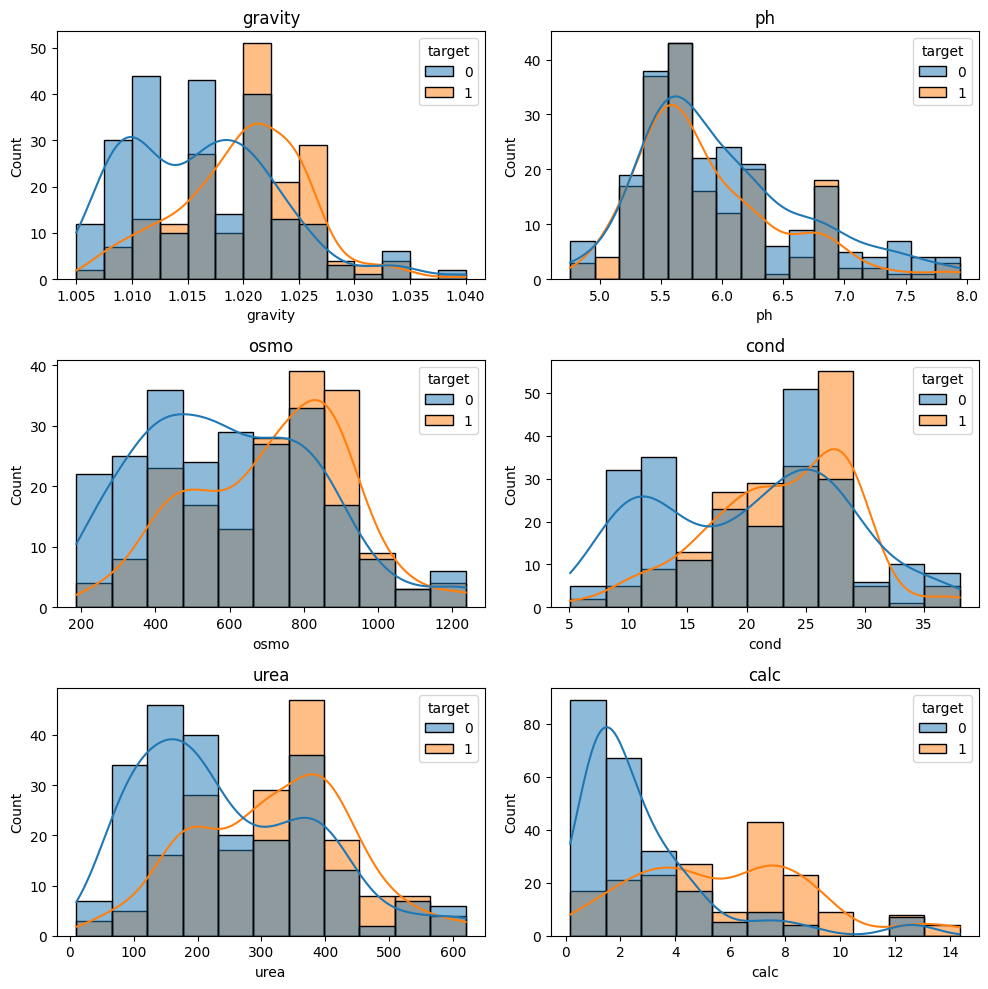

In [12]:
# Plotting histograms
def plot_histograms(data, columns, hue, nrows, ncols):
    # Create a grid of subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

    # Flatten the axes array to simplify indexing
    axes = axes.flatten()

    # Plot a histogram of each column on a separate subplot
    for i, column in enumerate(columns):
        sns.histplot(data=data, x=column, hue=hue, ax=axes[i], kde=True)
        axes[i].set_title(column)

    # Remove any unused subplots
    for i in range(len(columns), len(axes)):
        fig.delaxes(axes[i])

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    
plot_histograms(data, ["gravity", "ph", "osmo", "cond", "urea", "calc"], "target", 3, 2)

We can not that `ph` has a similar distribution for both individuals with and without the stone. For the rest, lower numbers are associated with the absence (`target` = 0) of the stone.

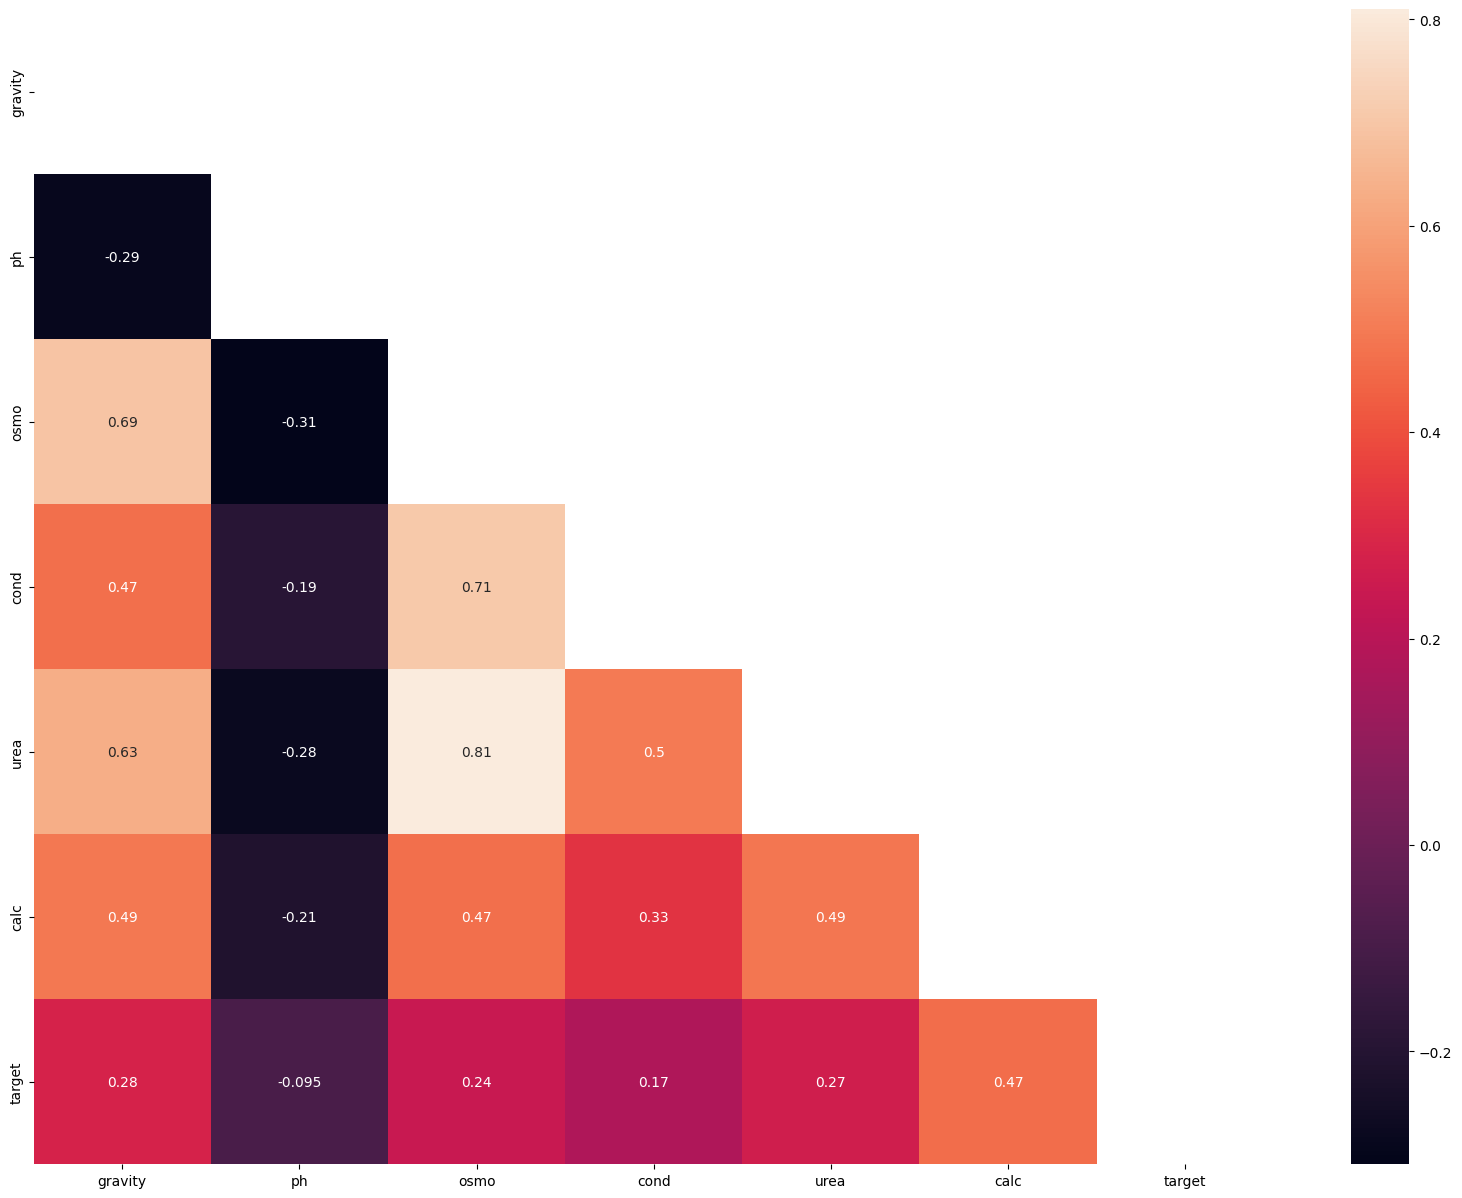

In [13]:
# Plotting the correlations
pearson = data.corr()

plt.figure(figsize=(20,15))
sns.heatmap(pearson, annot=True, mask=np.triu(pearson))
plt.show()

As we would expect, `ph` has the lowest correlation to `target`. `calc` is the variable most correlated to `target`.

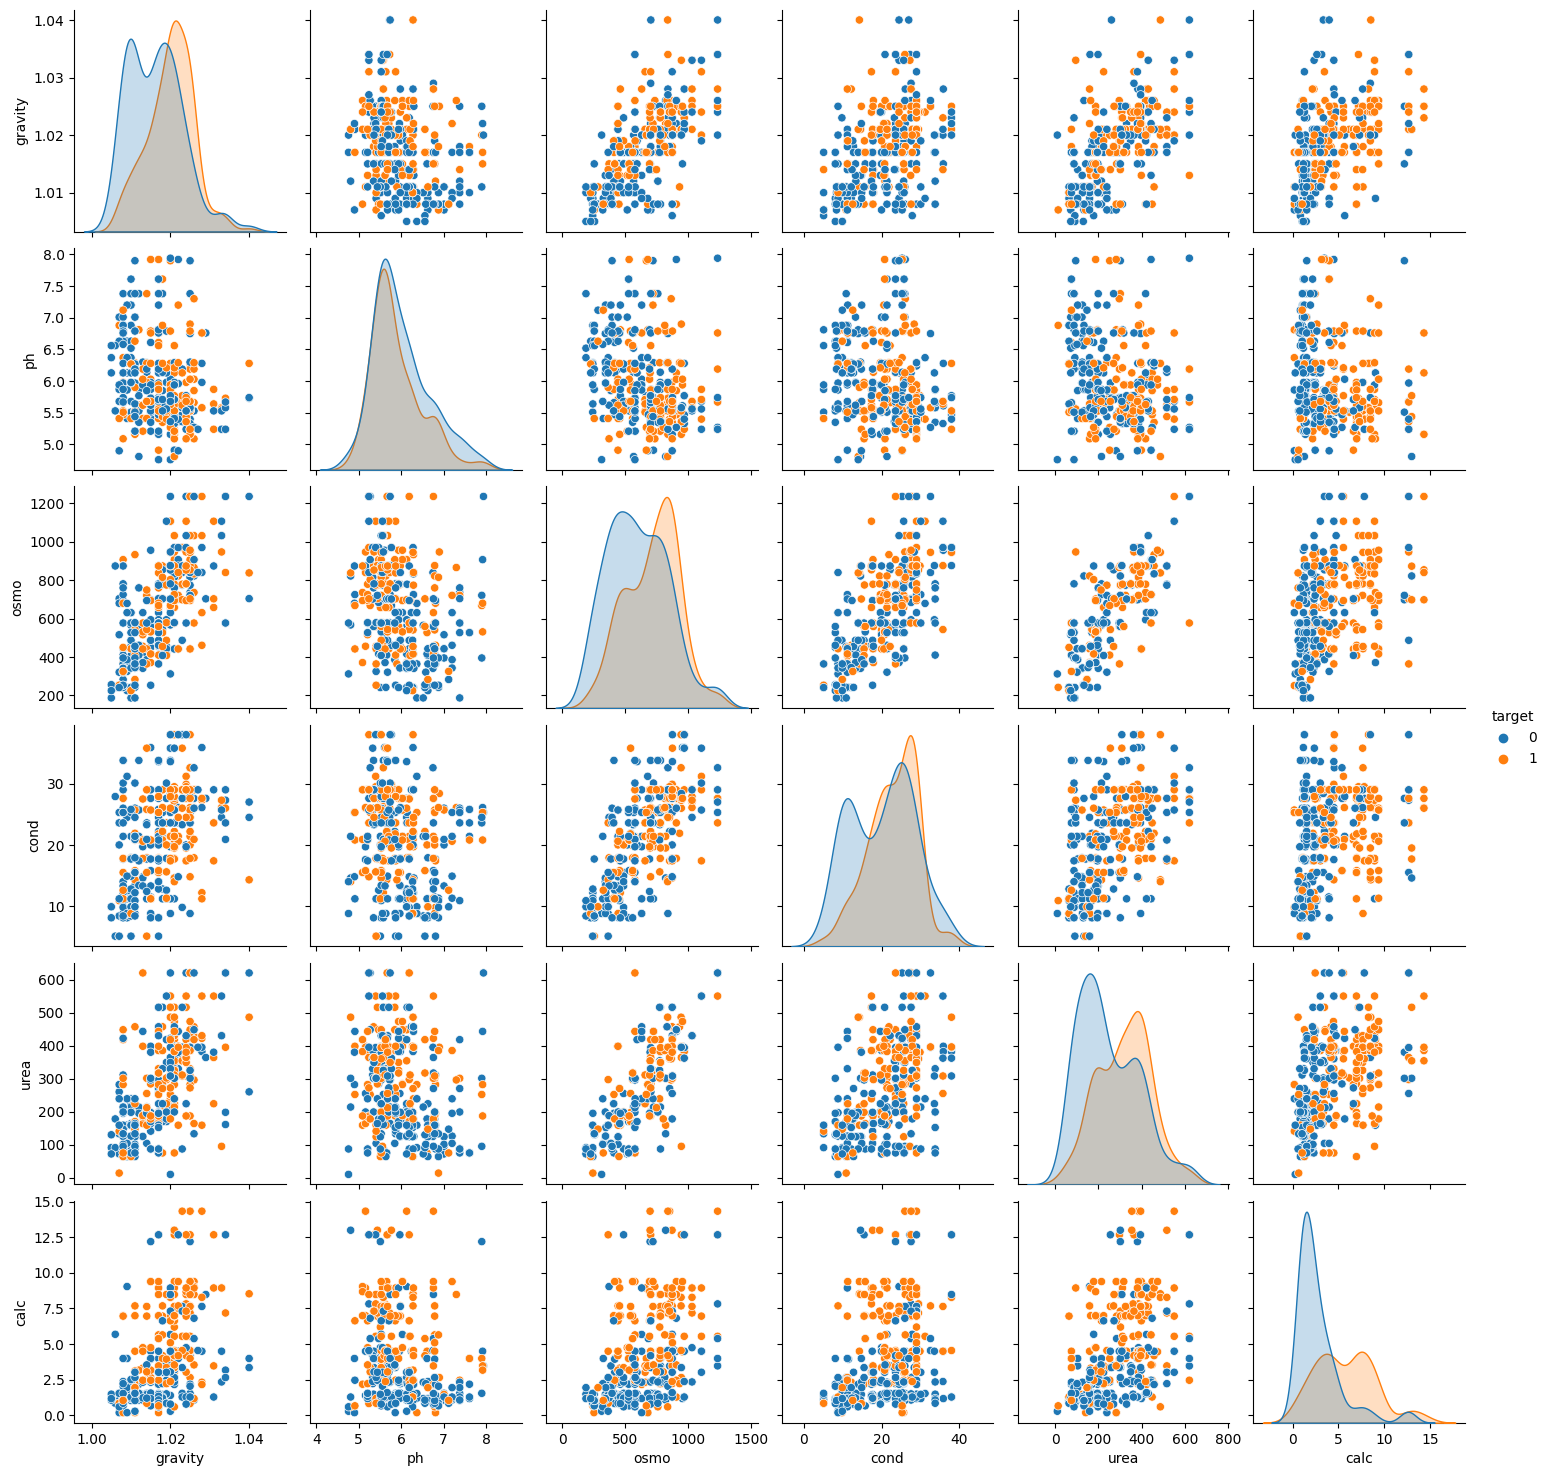

In [14]:
sns.pairplot(data=data, hue="target",
             vars=["gravity", "ph", "osmo", "cond", "urea", "calc"])
plt.show()

## Feature Engineering

### Combining Features

Let's try creating some new features. I'm not a biologist, so I don't know what would make sense here (or better yet, if it would make sense to combine the features). But we've seen that `ph` is not the best variable to predict the target. So let's combine it with some of the other features.

In [15]:
# Create a copy of the dataset
data_copy = data.copy()

In [16]:
for i in ["gravity", "osmo", "cond", "urea", "calc"]:
    print(f"ph / {i}:")
    data_copy["placeholder"] = data_copy["ph"] / data_copy[i]
    display(data_copy[["placeholder", "target"]].corr())

ph / gravity:


,placeholder,target
placeholder,1.000000,-0.110475
target,-0.110475,1.000000


ph / osmo:


,placeholder,target
placeholder,1.000000,-0.252036
target,-0.252036,1.000000


ph / cond:


,placeholder,target
placeholder,1.000000,-0.217256
target,-0.217256,1.000000


ph / urea:


,placeholder,target
placeholder,1.000000,-0.150496
target,-0.150496,1.000000


ph / calc:


,placeholder,target
placeholder,1.000000,-0.185012
target,-0.185012,1.000000


Let's select some of them to include in our dataset:

In [17]:
data_copy.drop(["placeholder"], axis=1, inplace=True)
data_copy["ph_osmo"] = data_copy["ph"] / data_copy["osmo"]
data_copy["ph_cond"] = data_copy["ph"] / data_copy["cond"]
data_copy["ph_calc"] = data_copy["ph"] / data_copy["calc"]

In [18]:
data_copy.head()

,gravity,ph,osmo,cond,urea,calc,target,ph_osmo,ph_cond,ph_calc
0,1.013,6.19,443,14.8,124,1.45,0,0.013973,0.418243,4.268966
1,1.025,5.40,703,23.6,394,4.18,0,0.007681,0.228814,1.291866
2,1.009,6.13,371,24.5,159,9.04,0,0.016523,0.250204,0.678097
3,1.021,4.91,442,20.8,398,6.63,1,0.011109,0.236058,0.740573
4,1.021,5.53,874,17.8,385,2.21,1,0.006327,0.310674,2.502262


### Cluster Analysis

Since we don't have many features, what about we try to create a cluster analysis?

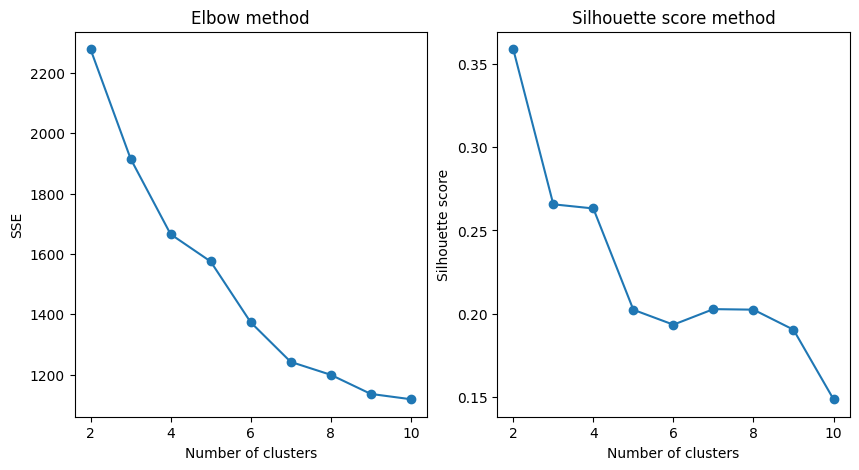

In [19]:
# Select the columns you want to cluster on
X = data_copy.drop(["target"], axis=1)

# Standardize the data (optional but recommended for KMeans)
X = (X - X.mean()) / X.std()

# Determine the optimal number of clusters using the Elbow method
sse = []
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init="auto")
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(2, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow method')

plt.subplot(1,2,2)
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score method')

plt.show()

In [20]:
# Choose the optimal number of clusters based on the Elbow method
optimal_k = 3  # change this to the elbow point you see in the plot

# Perform KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, n_init="auto")
kmeans.fit(X)

# Add the cluster labels to your DataFrame
data_copy['cluster'] = kmeans.labels_

# Print the results
data_copy.head()

,gravity,ph,osmo,cond,urea,calc,target,ph_osmo,ph_cond,ph_calc,cluster
0,1.013,6.19,443,14.8,124,1.45,0,0.013973,0.418243,4.268966,2
1,1.025,5.40,703,23.6,394,4.18,0,0.007681,0.228814,1.291866,0
2,1.009,6.13,371,24.5,159,9.04,0,0.016523,0.250204,0.678097,2
3,1.021,4.91,442,20.8,398,6.63,1,0.011109,0.236058,0.740573,0
4,1.021,5.53,874,17.8,385,2.21,1,0.006327,0.310674,2.502262,0


### Preparing the Data

In [21]:
one_hot_encoding = pd.get_dummies(data_copy["cluster"], drop_first=True, prefix="cluster")
data_copy = pd.concat([data_copy, one_hot_encoding], axis=1)
data_copy.drop(["cluster"], axis=1, inplace=True)

In [22]:
X, y = data_copy.drop(["target"], axis=1), data_copy["target"]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

While we're at it, let's prepare also the final test data:

In [23]:
test_data = pd.read_csv("./data/playground-series-s3e12/test.csv")

In [24]:
test_data["ph_osmo"] = test_data["ph"] / test_data["osmo"]
test_data["ph_cond"] = test_data["ph"] / test_data["cond"]
test_data["ph_calc"] = test_data["ph"] / test_data["calc"]

In [25]:
kmeans.fit(test_data)
test_data['cluster'] = kmeans.labels_

In [26]:
one_hot_encoding = pd.get_dummies(test_data["cluster"], drop_first=True, prefix="cluster")
test_data = pd.concat([test_data, one_hot_encoding], axis=1)
test_data.drop(["cluster"], axis=1, inplace=True)

In [27]:
test_data.head()

,id,gravity,ph,osmo,cond,urea,calc,ph_osmo,ph_cond,ph_calc,cluster_1,cluster_2
0,414,1.017,5.24,345,11.5,152,1.16,0.015188,0.455652,4.517241,False,False
1,415,1.020,5.68,874,29.0,385,3.46,0.006499,0.195862,1.641618,True,False
2,416,1.024,5.36,698,19.5,354,13.00,0.007679,0.274872,0.412308,False,True
3,417,1.020,5.33,668,25.3,252,3.46,0.007979,0.210672,1.540462,False,True
4,418,1.011,5.87,567,29.0,457,2.36,0.010353,0.202414,2.487288,False,True


In [28]:
test_data__scaled = scaler.fit_transform(test_data)

In [29]:
test_data__scaled

array([[-1.72578659, -0.20280456, -1.15389851, ...,  0.59183525,
        -0.66710282, -0.672779  ],
       [-1.71323541,  0.25474905, -0.42787688, ..., -0.36833341,
         1.49901929, -0.672779  ],
       [-1.70068424,  0.86482054, -0.95589261, ..., -0.77879952,
        -0.66710282,  1.4863722 ],
       ...,
       [ 1.70068424,  1.93244564, -0.42787688, ..., -0.49407494,
         1.49901929, -0.672779  ],
       [ 1.71323541,  0.10223118, -0.7743872 , ...,  0.19720776,
        -0.66710282, -0.672779  ],
       [ 1.72578659, -0.20280456,  0.41364819, ..., -0.33096254,
        -0.66710282,  1.4863722 ]])

## Fitting the Data

### Stochastic Gradient Descent

In [30]:
# sgd = SGDClassifier(loss="log_loss", random_state=42)
sgd = SGDClassifier(random_state=42)
sgd

SGDClassifier(random_state=42)

#### Training Set

In [31]:
sgd.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [32]:
cv_scores = cross_val_score(sgd, X_train, y_train, cv=3, scoring="accuracy")
cv_scores

array([0.59459459, 0.6       , 0.58181818])

In [33]:
y_train_pred = cross_val_predict(sgd, X_train, y_train, cv=3)

print(f"Precision: {precision_score(y_train, y_train_pred)}.")
print(f"Recall: {recall_score(y_train, y_train_pred)}.")
print(f"F1 Score: {f1_score(y_train, y_train_pred)}.")

Precision: 0.5291005291005291.
Recall: 0.684931506849315.
F1 Score: 0.5970149253731344.


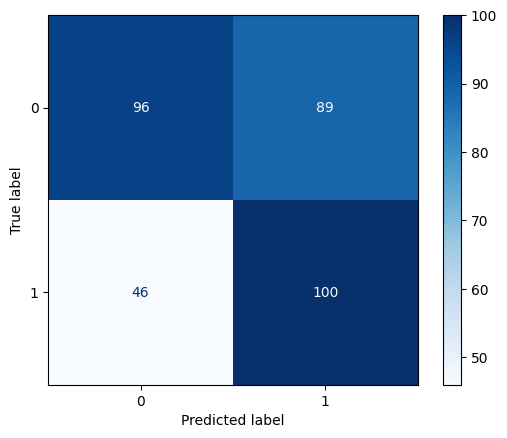

In [34]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Blues')
plt.show()

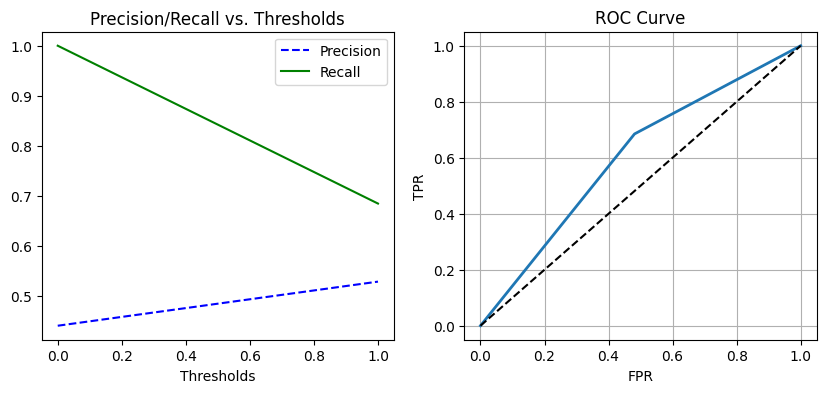

In [35]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_train, y_train_pred)
fpr, tpr, thresholds_roc = roc_curve(y_train, y_train_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [36]:
print(f"AUC: {roc_auc_score(y_train, y_train_pred)}.")

AUC: 0.601925212884117.


#### Test Set

In [37]:
y_pred = sgd.predict(X_test)

In [38]:
print(f"Precision: {precision_score(y_test, y_pred)}.")
print(f"Recall: {recall_score(y_test, y_pred)}.")
print(f"F1 Score: {f1_score(y_test, y_pred)}.")

Precision: 0.6756756756756757.
Recall: 0.6578947368421053.
F1 Score: 0.6666666666666667.


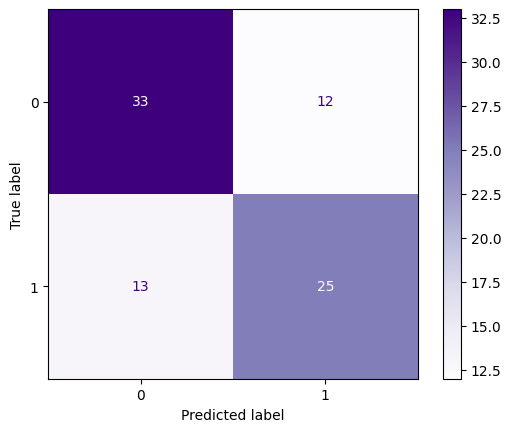

In [39]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Purples')
plt.show()

In [40]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}.")

Accuracy: 0.6987951807228916.


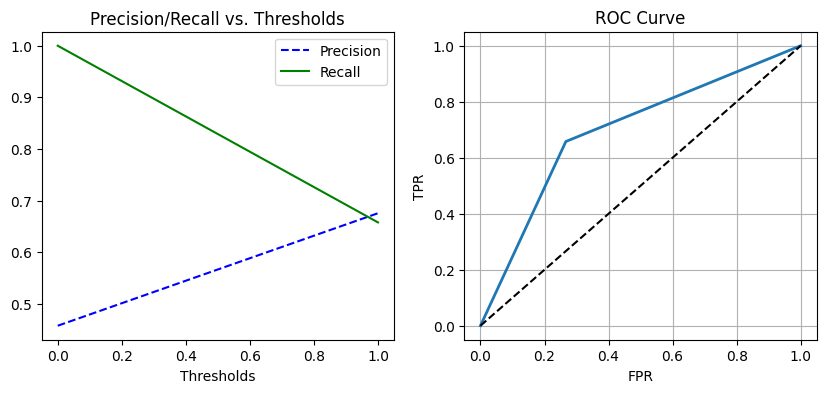

In [41]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [42]:
print(f"AUC: {roc_auc_score(y_test, y_pred)}.")

AUC: 0.6956140350877195.


In [43]:
model_scores = pd.concat([model_scores, pd.DataFrame([{
    "Model": "SGD",
    "Accuracy": accuracy_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred)
}])], ignore_index=True)

___

## CatBoost Classifier

In [44]:
cb_clf = cb.CatBoostClassifier(random_state=42)
cb_clf

In [45]:
cb_clf.fit(X_train, y_train, verbose=250)

Learning rate set to 0.006425
0:	learn: 0.6910709	total: 193ms	remaining: 3m 12s
250:	learn: 0.4537942	total: 932ms	remaining: 2.78s
500:	learn: 0.3713993	total: 1.76s	remaining: 1.75s
750:	learn: 0.3143748	total: 2.59s	remaining: 857ms
999:	learn: 0.2652563	total: 3.51s	remaining: 0us


In [46]:
cv_scores = cross_val_score(cb_clf, X_train, y_train, cv=3, scoring="accuracy", verbose=False)

Learning rate set to 0.005397
0:	learn: 0.6905634	total: 2.64ms	remaining: 2.64s
1:	learn: 0.6886165	total: 12.7ms	remaining: 6.33s
2:	learn: 0.6865211	total: 15.1ms	remaining: 5.02s
3:	learn: 0.6845718	total: 17.2ms	remaining: 4.29s
4:	learn: 0.6826555	total: 20.8ms	remaining: 4.15s
5:	learn: 0.6806401	total: 25.1ms	remaining: 4.16s
6:	learn: 0.6792757	total: 27.5ms	remaining: 3.89s
7:	learn: 0.6775007	total: 29.6ms	remaining: 3.68s
8:	learn: 0.6756314	total: 31.7ms	remaining: 3.49s
9:	learn: 0.6736345	total: 33.8ms	remaining: 3.35s
10:	learn: 0.6720533	total: 42.3ms	remaining: 3.81s
11:	learn: 0.6700074	total: 44.3ms	remaining: 3.65s
12:	learn: 0.6678392	total: 46.4ms	remaining: 3.52s
13:	learn: 0.6653856	total: 48.5ms	remaining: 3.41s
14:	learn: 0.6637559	total: 50.4ms	remaining: 3.31s
15:	learn: 0.6624753	total: 56.2ms	remaining: 3.46s
16:	learn: 0.6606462	total: 58.7ms	remaining: 3.39s
17:	learn: 0.6587016	total: 60.7ms	remaining: 3.31s
18:	learn: 0.6570998	total: 62.8ms	remaining

211:	learn: 0.4709906	total: 765ms	remaining: 2.84s
212:	learn: 0.4706231	total: 767ms	remaining: 2.83s
213:	learn: 0.4699287	total: 770ms	remaining: 2.83s
214:	learn: 0.4692777	total: 774ms	remaining: 2.83s
215:	learn: 0.4689063	total: 779ms	remaining: 2.83s
216:	learn: 0.4681917	total: 781ms	remaining: 2.82s
217:	learn: 0.4676375	total: 784ms	remaining: 2.81s
218:	learn: 0.4672945	total: 792ms	remaining: 2.83s
219:	learn: 0.4667540	total: 795ms	remaining: 2.82s
220:	learn: 0.4658581	total: 797ms	remaining: 2.81s
221:	learn: 0.4654465	total: 799ms	remaining: 2.8s
222:	learn: 0.4647822	total: 802ms	remaining: 2.79s
223:	learn: 0.4644487	total: 805ms	remaining: 2.79s
224:	learn: 0.4638747	total: 809ms	remaining: 2.79s
225:	learn: 0.4637124	total: 811ms	remaining: 2.78s
226:	learn: 0.4632838	total: 813ms	remaining: 2.77s
227:	learn: 0.4626278	total: 816ms	remaining: 2.76s
228:	learn: 0.4618466	total: 818ms	remaining: 2.75s
229:	learn: 0.4615007	total: 827ms	remaining: 2.77s
230:	learn: 0

387:	learn: 0.3938354	total: 1.36s	remaining: 2.14s
388:	learn: 0.3934926	total: 1.36s	remaining: 2.15s
389:	learn: 0.3930477	total: 1.37s	remaining: 2.14s
390:	learn: 0.3927391	total: 1.37s	remaining: 2.13s
391:	learn: 0.3925060	total: 1.38s	remaining: 2.14s
392:	learn: 0.3920729	total: 1.38s	remaining: 2.13s
393:	learn: 0.3917114	total: 1.38s	remaining: 2.13s
394:	learn: 0.3913467	total: 1.39s	remaining: 2.12s
395:	learn: 0.3909088	total: 1.39s	remaining: 2.13s
396:	learn: 0.3903883	total: 1.4s	remaining: 2.12s
397:	learn: 0.3901337	total: 1.4s	remaining: 2.12s
398:	learn: 0.3895600	total: 1.4s	remaining: 2.11s
399:	learn: 0.3893639	total: 1.4s	remaining: 2.11s
400:	learn: 0.3889643	total: 1.41s	remaining: 2.1s
401:	learn: 0.3888250	total: 1.41s	remaining: 2.1s
402:	learn: 0.3884526	total: 1.41s	remaining: 2.1s
403:	learn: 0.3882252	total: 1.42s	remaining: 2.09s
404:	learn: 0.3879691	total: 1.42s	remaining: 2.08s
405:	learn: 0.3876562	total: 1.43s	remaining: 2.09s
406:	learn: 0.38750

558:	learn: 0.3455149	total: 1.98s	remaining: 1.56s
559:	learn: 0.3454258	total: 1.98s	remaining: 1.56s
560:	learn: 0.3451208	total: 1.99s	remaining: 1.55s
561:	learn: 0.3448803	total: 1.99s	remaining: 1.55s
562:	learn: 0.3445447	total: 2s	remaining: 1.55s
563:	learn: 0.3444654	total: 2s	remaining: 1.54s
564:	learn: 0.3444146	total: 2s	remaining: 1.54s
565:	learn: 0.3443194	total: 2s	remaining: 1.54s
566:	learn: 0.3439767	total: 2.01s	remaining: 1.53s
567:	learn: 0.3436569	total: 2.01s	remaining: 1.53s
568:	learn: 0.3434834	total: 2.01s	remaining: 1.52s
569:	learn: 0.3430453	total: 2.01s	remaining: 1.52s
570:	learn: 0.3427997	total: 2.02s	remaining: 1.51s
571:	learn: 0.3425536	total: 2.02s	remaining: 1.51s
572:	learn: 0.3424334	total: 2.02s	remaining: 1.51s
573:	learn: 0.3422041	total: 2.03s	remaining: 1.5s
574:	learn: 0.3419485	total: 2.03s	remaining: 1.5s
575:	learn: 0.3419117	total: 2.03s	remaining: 1.5s
576:	learn: 0.3416988	total: 2.03s	remaining: 1.49s
577:	learn: 0.3414718	total

780:	learn: 0.2947777	total: 2.57s	remaining: 720ms
781:	learn: 0.2946370	total: 2.57s	remaining: 717ms
782:	learn: 0.2944329	total: 2.57s	remaining: 713ms
783:	learn: 0.2943444	total: 2.58s	remaining: 710ms
784:	learn: 0.2940815	total: 2.58s	remaining: 707ms
785:	learn: 0.2938685	total: 2.58s	remaining: 703ms
786:	learn: 0.2935144	total: 2.58s	remaining: 700ms
787:	learn: 0.2933685	total: 2.59s	remaining: 696ms
788:	learn: 0.2930211	total: 2.59s	remaining: 693ms
789:	learn: 0.2928087	total: 2.6s	remaining: 690ms
790:	learn: 0.2925970	total: 2.6s	remaining: 687ms
791:	learn: 0.2924167	total: 2.6s	remaining: 683ms
792:	learn: 0.2920822	total: 2.6s	remaining: 680ms
793:	learn: 0.2918886	total: 2.6s	remaining: 676ms
794:	learn: 0.2916672	total: 2.61s	remaining: 673ms
795:	learn: 0.2913528	total: 2.61s	remaining: 669ms
796:	learn: 0.2911815	total: 2.61s	remaining: 666ms
797:	learn: 0.2909603	total: 2.62s	remaining: 662ms
798:	learn: 0.2907933	total: 2.62s	remaining: 659ms
799:	learn: 0.290

Learning rate set to 0.005407
0:	learn: 0.6907773	total: 10.3ms	remaining: 10.3s
1:	learn: 0.6887066	total: 17.9ms	remaining: 8.94s
2:	learn: 0.6865231	total: 28.3ms	remaining: 9.41s
3:	learn: 0.6844406	total: 31.8ms	remaining: 7.92s
4:	learn: 0.6822190	total: 36ms	remaining: 7.16s
5:	learn: 0.6797454	total: 38.9ms	remaining: 6.45s
6:	learn: 0.6774557	total: 41.6ms	remaining: 5.9s
7:	learn: 0.6752580	total: 43.8ms	remaining: 5.43s
8:	learn: 0.6735649	total: 46.1ms	remaining: 5.08s
9:	learn: 0.6709663	total: 48.2ms	remaining: 4.77s
10:	learn: 0.6692061	total: 53.3ms	remaining: 4.79s
11:	learn: 0.6668244	total: 55.4ms	remaining: 4.56s
12:	learn: 0.6646526	total: 57.4ms	remaining: 4.36s
13:	learn: 0.6628687	total: 59.4ms	remaining: 4.18s
14:	learn: 0.6608995	total: 61.4ms	remaining: 4.03s
15:	learn: 0.6585059	total: 63.4ms	remaining: 3.9s
16:	learn: 0.6563170	total: 65.8ms	remaining: 3.81s
17:	learn: 0.6543225	total: 68.6ms	remaining: 3.74s
18:	learn: 0.6527846	total: 71.1ms	remaining: 3.

221:	learn: 0.4395667	total: 577ms	remaining: 2.02s
222:	learn: 0.4391415	total: 580ms	remaining: 2.02s
223:	learn: 0.4385121	total: 582ms	remaining: 2.02s
224:	learn: 0.4378702	total: 589ms	remaining: 2.03s
225:	learn: 0.4373187	total: 592ms	remaining: 2.03s
226:	learn: 0.4369120	total: 594ms	remaining: 2.02s
227:	learn: 0.4365452	total: 596ms	remaining: 2.02s
228:	learn: 0.4363312	total: 600ms	remaining: 2.02s
229:	learn: 0.4358911	total: 604ms	remaining: 2.02s
230:	learn: 0.4351934	total: 607ms	remaining: 2.02s
231:	learn: 0.4347814	total: 609ms	remaining: 2.02s
232:	learn: 0.4342710	total: 612ms	remaining: 2.01s
233:	learn: 0.4338203	total: 614ms	remaining: 2.01s
234:	learn: 0.4332900	total: 620ms	remaining: 2.02s
235:	learn: 0.4326738	total: 622ms	remaining: 2.01s
236:	learn: 0.4316182	total: 624ms	remaining: 2.01s
237:	learn: 0.4310617	total: 626ms	remaining: 2s
238:	learn: 0.4306965	total: 628ms	remaining: 2s
239:	learn: 0.4299965	total: 630ms	remaining: 1.99s
240:	learn: 0.4295

379:	learn: 0.3717571	total: 979ms	remaining: 1.6s
380:	learn: 0.3712580	total: 982ms	remaining: 1.59s
381:	learn: 0.3710158	total: 985ms	remaining: 1.59s
382:	learn: 0.3706812	total: 987ms	remaining: 1.59s
383:	learn: 0.3705274	total: 989ms	remaining: 1.59s
384:	learn: 0.3704107	total: 991ms	remaining: 1.58s
385:	learn: 0.3701089	total: 999ms	remaining: 1.59s
386:	learn: 0.3699030	total: 1s	remaining: 1.59s
387:	learn: 0.3694674	total: 1s	remaining: 1.58s
388:	learn: 0.3692023	total: 1s	remaining: 1.58s
389:	learn: 0.3690616	total: 1.01s	remaining: 1.58s
390:	learn: 0.3685831	total: 1.01s	remaining: 1.58s
391:	learn: 0.3683000	total: 1.01s	remaining: 1.57s
392:	learn: 0.3678428	total: 1.02s	remaining: 1.57s
393:	learn: 0.3675780	total: 1.02s	remaining: 1.57s
394:	learn: 0.3668614	total: 1.02s	remaining: 1.56s
395:	learn: 0.3665773	total: 1.02s	remaining: 1.56s
396:	learn: 0.3663431	total: 1.02s	remaining: 1.56s
397:	learn: 0.3661427	total: 1.03s	remaining: 1.56s
398:	learn: 0.3658239	

590:	learn: 0.3096664	total: 1.56s	remaining: 1.08s
591:	learn: 0.3092768	total: 1.57s	remaining: 1.08s
592:	learn: 0.3089690	total: 1.57s	remaining: 1.08s
593:	learn: 0.3086766	total: 1.57s	remaining: 1.07s
594:	learn: 0.3086020	total: 1.58s	remaining: 1.07s
595:	learn: 0.3084811	total: 1.58s	remaining: 1.07s
596:	learn: 0.3082268	total: 1.58s	remaining: 1.07s
597:	learn: 0.3079560	total: 1.6s	remaining: 1.08s
598:	learn: 0.3075673	total: 1.61s	remaining: 1.07s
599:	learn: 0.3072995	total: 1.61s	remaining: 1.07s
600:	learn: 0.3069416	total: 1.61s	remaining: 1.07s
601:	learn: 0.3065702	total: 1.62s	remaining: 1.07s
602:	learn: 0.3063657	total: 1.62s	remaining: 1.07s
603:	learn: 0.3062175	total: 1.63s	remaining: 1.07s
604:	learn: 0.3060215	total: 1.63s	remaining: 1.06s
605:	learn: 0.3056733	total: 1.63s	remaining: 1.06s
606:	learn: 0.3054688	total: 1.64s	remaining: 1.06s
607:	learn: 0.3052144	total: 1.64s	remaining: 1.05s
608:	learn: 0.3050013	total: 1.64s	remaining: 1.05s
609:	learn: 0

795:	learn: 0.2648805	total: 2.14s	remaining: 550ms
796:	learn: 0.2647363	total: 2.15s	remaining: 547ms
797:	learn: 0.2646188	total: 2.15s	remaining: 544ms
798:	learn: 0.2643909	total: 2.15s	remaining: 541ms
799:	learn: 0.2641907	total: 2.15s	remaining: 539ms
800:	learn: 0.2640406	total: 2.16s	remaining: 536ms
801:	learn: 0.2637478	total: 2.16s	remaining: 534ms
802:	learn: 0.2636293	total: 2.17s	remaining: 532ms
803:	learn: 0.2633916	total: 2.17s	remaining: 529ms
804:	learn: 0.2631675	total: 2.17s	remaining: 526ms
805:	learn: 0.2629555	total: 2.17s	remaining: 523ms
806:	learn: 0.2629024	total: 2.18s	remaining: 521ms
807:	learn: 0.2626062	total: 2.18s	remaining: 518ms
808:	learn: 0.2624043	total: 2.18s	remaining: 515ms
809:	learn: 0.2622399	total: 2.18s	remaining: 512ms
810:	learn: 0.2620654	total: 2.19s	remaining: 509ms
811:	learn: 0.2619681	total: 2.19s	remaining: 507ms
812:	learn: 0.2616765	total: 2.19s	remaining: 505ms
813:	learn: 0.2613623	total: 2.2s	remaining: 502ms
814:	learn: 0

Learning rate set to 0.005407
0:	learn: 0.6910418	total: 10.2ms	remaining: 10.2s
1:	learn: 0.6887029	total: 20ms	remaining: 9.99s
2:	learn: 0.6871447	total: 26.6ms	remaining: 8.84s
3:	learn: 0.6851829	total: 30.2ms	remaining: 7.51s
4:	learn: 0.6831344	total: 33.4ms	remaining: 6.64s
5:	learn: 0.6810400	total: 39.9ms	remaining: 6.61s
6:	learn: 0.6790024	total: 42.4ms	remaining: 6.02s
7:	learn: 0.6772473	total: 44.9ms	remaining: 5.56s
8:	learn: 0.6754959	total: 47ms	remaining: 5.17s
9:	learn: 0.6737796	total: 49.4ms	remaining: 4.89s
10:	learn: 0.6717399	total: 52.1ms	remaining: 4.68s
11:	learn: 0.6700177	total: 55.1ms	remaining: 4.54s
12:	learn: 0.6682116	total: 57.2ms	remaining: 4.34s
13:	learn: 0.6669793	total: 58.8ms	remaining: 4.14s
14:	learn: 0.6651940	total: 60.8ms	remaining: 3.99s
15:	learn: 0.6636883	total: 62.8ms	remaining: 3.86s
16:	learn: 0.6619236	total: 64.9ms	remaining: 3.75s
17:	learn: 0.6598411	total: 67ms	remaining: 3.66s
18:	learn: 0.6581135	total: 85.4ms	remaining: 4.41

197:	learn: 0.4862921	total: 597ms	remaining: 2.42s
198:	learn: 0.4857435	total: 600ms	remaining: 2.42s
199:	learn: 0.4852859	total: 603ms	remaining: 2.41s
200:	learn: 0.4849164	total: 605ms	remaining: 2.4s
201:	learn: 0.4842027	total: 614ms	remaining: 2.43s
202:	learn: 0.4837382	total: 617ms	remaining: 2.42s
203:	learn: 0.4831224	total: 619ms	remaining: 2.42s
204:	learn: 0.4823666	total: 623ms	remaining: 2.42s
205:	learn: 0.4816750	total: 629ms	remaining: 2.42s
206:	learn: 0.4810267	total: 632ms	remaining: 2.42s
207:	learn: 0.4805051	total: 634ms	remaining: 2.42s
208:	learn: 0.4800273	total: 636ms	remaining: 2.41s
209:	learn: 0.4793975	total: 645ms	remaining: 2.42s
210:	learn: 0.4789923	total: 647ms	remaining: 2.42s
211:	learn: 0.4785088	total: 648ms	remaining: 2.41s
212:	learn: 0.4780356	total: 650ms	remaining: 2.4s
213:	learn: 0.4775695	total: 652ms	remaining: 2.4s
214:	learn: 0.4772335	total: 657ms	remaining: 2.4s
215:	learn: 0.4764070	total: 660ms	remaining: 2.39s
216:	learn: 0.47

391:	learn: 0.3978970	total: 1.2s	remaining: 1.86s
392:	learn: 0.3975194	total: 1.2s	remaining: 1.85s
393:	learn: 0.3972309	total: 1.2s	remaining: 1.85s
394:	learn: 0.3969696	total: 1.21s	remaining: 1.85s
395:	learn: 0.3965727	total: 1.21s	remaining: 1.85s
396:	learn: 0.3963343	total: 1.22s	remaining: 1.85s
397:	learn: 0.3959767	total: 1.22s	remaining: 1.84s
398:	learn: 0.3954347	total: 1.22s	remaining: 1.84s
399:	learn: 0.3948071	total: 1.23s	remaining: 1.84s
400:	learn: 0.3942945	total: 1.23s	remaining: 1.84s
401:	learn: 0.3940987	total: 1.23s	remaining: 1.83s
402:	learn: 0.3938667	total: 1.24s	remaining: 1.83s
403:	learn: 0.3935751	total: 1.24s	remaining: 1.83s
404:	learn: 0.3932618	total: 1.25s	remaining: 1.83s
405:	learn: 0.3931115	total: 1.25s	remaining: 1.83s
406:	learn: 0.3926411	total: 1.25s	remaining: 1.82s
407:	learn: 0.3920644	total: 1.25s	remaining: 1.82s
408:	learn: 0.3918039	total: 1.26s	remaining: 1.81s
409:	learn: 0.3911316	total: 1.26s	remaining: 1.81s
410:	learn: 0.3

556:	learn: 0.3482021	total: 1.75s	remaining: 1.39s
557:	learn: 0.3479852	total: 1.75s	remaining: 1.39s
558:	learn: 0.3476976	total: 1.75s	remaining: 1.38s
559:	learn: 0.3474490	total: 1.76s	remaining: 1.38s
560:	learn: 0.3473480	total: 1.77s	remaining: 1.38s
561:	learn: 0.3472045	total: 1.77s	remaining: 1.38s
562:	learn: 0.3468356	total: 1.77s	remaining: 1.37s
563:	learn: 0.3465347	total: 1.77s	remaining: 1.37s
564:	learn: 0.3462761	total: 1.78s	remaining: 1.37s
565:	learn: 0.3460349	total: 1.78s	remaining: 1.36s
566:	learn: 0.3457535	total: 1.78s	remaining: 1.36s
567:	learn: 0.3456719	total: 1.78s	remaining: 1.36s
568:	learn: 0.3454092	total: 1.79s	remaining: 1.35s
569:	learn: 0.3452212	total: 1.79s	remaining: 1.35s
570:	learn: 0.3450071	total: 1.8s	remaining: 1.35s
571:	learn: 0.3447742	total: 1.8s	remaining: 1.35s
572:	learn: 0.3445916	total: 1.81s	remaining: 1.34s
573:	learn: 0.3443497	total: 1.81s	remaining: 1.34s
574:	learn: 0.3440488	total: 1.81s	remaining: 1.34s
575:	learn: 0.

732:	learn: 0.3058940	total: 2.33s	remaining: 851ms
733:	learn: 0.3056266	total: 2.34s	remaining: 847ms
734:	learn: 0.3052285	total: 2.34s	remaining: 844ms
735:	learn: 0.3050116	total: 2.34s	remaining: 841ms
736:	learn: 0.3048072	total: 2.35s	remaining: 838ms
737:	learn: 0.3045098	total: 2.35s	remaining: 835ms
738:	learn: 0.3044082	total: 2.35s	remaining: 831ms
739:	learn: 0.3042254	total: 2.36s	remaining: 828ms
740:	learn: 0.3041312	total: 2.37s	remaining: 828ms
741:	learn: 0.3039159	total: 2.37s	remaining: 825ms
742:	learn: 0.3037279	total: 2.37s	remaining: 821ms
743:	learn: 0.3035823	total: 2.38s	remaining: 818ms
744:	learn: 0.3031143	total: 2.38s	remaining: 815ms
745:	learn: 0.3028708	total: 2.38s	remaining: 812ms
746:	learn: 0.3026285	total: 2.39s	remaining: 808ms
747:	learn: 0.3024911	total: 2.4s	remaining: 807ms
748:	learn: 0.3024078	total: 2.4s	remaining: 804ms
749:	learn: 0.3021597	total: 2.4s	remaining: 801ms
750:	learn: 0.3019775	total: 2.41s	remaining: 799ms
751:	learn: 0.3

917:	learn: 0.2671645	total: 2.91s	remaining: 260ms
918:	learn: 0.2668811	total: 2.92s	remaining: 257ms
919:	learn: 0.2667101	total: 2.92s	remaining: 254ms
920:	learn: 0.2666017	total: 2.93s	remaining: 252ms
921:	learn: 0.2663267	total: 2.94s	remaining: 249ms
922:	learn: 0.2660468	total: 2.94s	remaining: 246ms
923:	learn: 0.2659031	total: 2.94s	remaining: 242ms
924:	learn: 0.2655825	total: 2.95s	remaining: 239ms
925:	learn: 0.2654740	total: 2.95s	remaining: 236ms
926:	learn: 0.2652652	total: 2.96s	remaining: 233ms
927:	learn: 0.2649953	total: 2.96s	remaining: 230ms
928:	learn: 0.2648012	total: 2.97s	remaining: 227ms
929:	learn: 0.2646175	total: 2.97s	remaining: 223ms
930:	learn: 0.2644975	total: 2.97s	remaining: 220ms
931:	learn: 0.2644225	total: 2.98s	remaining: 217ms
932:	learn: 0.2641947	total: 2.98s	remaining: 214ms
933:	learn: 0.2640020	total: 2.98s	remaining: 211ms
934:	learn: 0.2638383	total: 2.98s	remaining: 207ms
935:	learn: 0.2636795	total: 2.99s	remaining: 205ms
936:	learn: 

In [47]:
print(f"3-fold CV Scores: {cv_scores}.")

3-fold CV Scores: [0.71171171 0.72727273 0.72727273].


In [48]:
y_train_pred = cross_val_predict(cb_clf, X_train, y_train, cv=3)

Learning rate set to 0.005397
0:	learn: 0.6905634	total: 7.27ms	remaining: 7.26s
1:	learn: 0.6886165	total: 16.5ms	remaining: 8.24s
2:	learn: 0.6865211	total: 18.7ms	remaining: 6.23s
3:	learn: 0.6845718	total: 21ms	remaining: 5.22s
4:	learn: 0.6826555	total: 23ms	remaining: 4.57s
5:	learn: 0.6806401	total: 27.5ms	remaining: 4.56s
6:	learn: 0.6792757	total: 30.9ms	remaining: 4.38s
7:	learn: 0.6775007	total: 33ms	remaining: 4.09s
8:	learn: 0.6756314	total: 35ms	remaining: 3.86s
9:	learn: 0.6736345	total: 36.9ms	remaining: 3.65s
10:	learn: 0.6720533	total: 38.8ms	remaining: 3.48s
11:	learn: 0.6700074	total: 46.8ms	remaining: 3.85s
12:	learn: 0.6678392	total: 49.1ms	remaining: 3.73s
13:	learn: 0.6653856	total: 51ms	remaining: 3.59s
14:	learn: 0.6637559	total: 52.8ms	remaining: 3.47s
15:	learn: 0.6624753	total: 54.8ms	remaining: 3.37s
16:	learn: 0.6606462	total: 59.2ms	remaining: 3.42s
17:	learn: 0.6587016	total: 62.6ms	remaining: 3.42s
18:	learn: 0.6570998	total: 64.7ms	remaining: 3.34s
19

180:	learn: 0.4893703	total: 601ms	remaining: 2.72s
181:	learn: 0.4887905	total: 603ms	remaining: 2.71s
182:	learn: 0.4881701	total: 606ms	remaining: 2.7s
183:	learn: 0.4870287	total: 616ms	remaining: 2.73s
184:	learn: 0.4862877	total: 618ms	remaining: 2.72s
185:	learn: 0.4856868	total: 620ms	remaining: 2.71s
186:	learn: 0.4850785	total: 626ms	remaining: 2.72s
187:	learn: 0.4846459	total: 631ms	remaining: 2.72s
188:	learn: 0.4838710	total: 633ms	remaining: 2.72s
189:	learn: 0.4826918	total: 635ms	remaining: 2.71s
190:	learn: 0.4822415	total: 637ms	remaining: 2.7s
191:	learn: 0.4815157	total: 646ms	remaining: 2.72s
192:	learn: 0.4811664	total: 648ms	remaining: 2.71s
193:	learn: 0.4806378	total: 650ms	remaining: 2.7s
194:	learn: 0.4801826	total: 652ms	remaining: 2.69s
195:	learn: 0.4796532	total: 653ms	remaining: 2.68s
196:	learn: 0.4791619	total: 658ms	remaining: 2.68s
197:	learn: 0.4787057	total: 662ms	remaining: 2.68s
198:	learn: 0.4781329	total: 664ms	remaining: 2.67s
199:	learn: 0.4

349:	learn: 0.4073931	total: 1.23s	remaining: 2.29s
350:	learn: 0.4071199	total: 1.24s	remaining: 2.29s
351:	learn: 0.4068682	total: 1.24s	remaining: 2.28s
352:	learn: 0.4066802	total: 1.24s	remaining: 2.27s
353:	learn: 0.4063801	total: 1.25s	remaining: 2.28s
354:	learn: 0.4060393	total: 1.25s	remaining: 2.27s
355:	learn: 0.4057897	total: 1.25s	remaining: 2.27s
356:	learn: 0.4052393	total: 1.26s	remaining: 2.26s
357:	learn: 0.4049886	total: 1.26s	remaining: 2.26s
358:	learn: 0.4047736	total: 1.26s	remaining: 2.25s
359:	learn: 0.4043910	total: 1.26s	remaining: 2.25s
360:	learn: 0.4041153	total: 1.27s	remaining: 2.24s
361:	learn: 0.4035422	total: 1.27s	remaining: 2.23s
362:	learn: 0.4032221	total: 1.27s	remaining: 2.23s
363:	learn: 0.4026878	total: 1.27s	remaining: 2.22s
364:	learn: 0.4024230	total: 1.28s	remaining: 2.22s
365:	learn: 0.4021188	total: 1.28s	remaining: 2.22s
366:	learn: 0.4017992	total: 1.28s	remaining: 2.21s
367:	learn: 0.4014362	total: 1.28s	remaining: 2.2s
368:	learn: 0

579:	learn: 0.3408553	total: 1.82s	remaining: 1.31s
580:	learn: 0.3405092	total: 1.82s	remaining: 1.31s
581:	learn: 0.3401536	total: 1.82s	remaining: 1.31s
582:	learn: 0.3400634	total: 1.82s	remaining: 1.3s
583:	learn: 0.3397686	total: 1.83s	remaining: 1.3s
584:	learn: 0.3397084	total: 1.83s	remaining: 1.3s
585:	learn: 0.3395750	total: 1.84s	remaining: 1.3s
586:	learn: 0.3391104	total: 1.84s	remaining: 1.29s
587:	learn: 0.3389791	total: 1.84s	remaining: 1.29s
588:	learn: 0.3388084	total: 1.85s	remaining: 1.29s
589:	learn: 0.3384056	total: 1.85s	remaining: 1.28s
590:	learn: 0.3381283	total: 1.85s	remaining: 1.28s
591:	learn: 0.3380927	total: 1.85s	remaining: 1.28s
592:	learn: 0.3378920	total: 1.85s	remaining: 1.27s
593:	learn: 0.3376601	total: 1.86s	remaining: 1.27s
594:	learn: 0.3374881	total: 1.86s	remaining: 1.26s
595:	learn: 0.3371264	total: 1.86s	remaining: 1.26s
596:	learn: 0.3369621	total: 1.87s	remaining: 1.26s
597:	learn: 0.3367404	total: 1.87s	remaining: 1.26s
598:	learn: 0.33

810:	learn: 0.2881473	total: 2.4s	remaining: 559ms
811:	learn: 0.2879456	total: 2.4s	remaining: 556ms
812:	learn: 0.2877250	total: 2.4s	remaining: 553ms
813:	learn: 0.2874616	total: 2.41s	remaining: 550ms
814:	learn: 0.2873137	total: 2.41s	remaining: 547ms
815:	learn: 0.2870691	total: 2.41s	remaining: 544ms
816:	learn: 0.2870195	total: 2.41s	remaining: 541ms
817:	learn: 0.2867900	total: 2.42s	remaining: 538ms
818:	learn: 0.2863718	total: 2.42s	remaining: 535ms
819:	learn: 0.2862130	total: 2.42s	remaining: 532ms
820:	learn: 0.2860498	total: 2.43s	remaining: 529ms
821:	learn: 0.2859678	total: 2.43s	remaining: 526ms
822:	learn: 0.2857801	total: 2.43s	remaining: 523ms
823:	learn: 0.2855718	total: 2.43s	remaining: 520ms
824:	learn: 0.2854722	total: 2.44s	remaining: 517ms
825:	learn: 0.2852077	total: 2.44s	remaining: 513ms
826:	learn: 0.2850452	total: 2.44s	remaining: 510ms
827:	learn: 0.2849074	total: 2.44s	remaining: 507ms
828:	learn: 0.2847553	total: 2.44s	remaining: 504ms
829:	learn: 0.2

Learning rate set to 0.005407
0:	learn: 0.6907773	total: 21.8ms	remaining: 21.8s
1:	learn: 0.6887066	total: 24.5ms	remaining: 12.2s
2:	learn: 0.6865231	total: 26.9ms	remaining: 8.95s
3:	learn: 0.6844406	total: 30.1ms	remaining: 7.5s
4:	learn: 0.6822190	total: 32.9ms	remaining: 6.55s
5:	learn: 0.6797454	total: 34.9ms	remaining: 5.79s
6:	learn: 0.6774557	total: 37ms	remaining: 5.25s
7:	learn: 0.6752580	total: 39ms	remaining: 4.84s
8:	learn: 0.6735649	total: 41.1ms	remaining: 4.52s
9:	learn: 0.6709663	total: 43.1ms	remaining: 4.27s
10:	learn: 0.6692061	total: 49.3ms	remaining: 4.43s
11:	learn: 0.6668244	total: 51.8ms	remaining: 4.26s
12:	learn: 0.6646526	total: 53.9ms	remaining: 4.09s
13:	learn: 0.6628687	total: 55.9ms	remaining: 3.94s
14:	learn: 0.6608995	total: 58.1ms	remaining: 3.81s
15:	learn: 0.6585059	total: 60.5ms	remaining: 3.72s
16:	learn: 0.6563170	total: 63.4ms	remaining: 3.66s
17:	learn: 0.6543225	total: 65.5ms	remaining: 3.57s
18:	learn: 0.6527846	total: 67.6ms	remaining: 3.4

209:	learn: 0.4469335	total: 574ms	remaining: 2.16s
210:	learn: 0.4462384	total: 577ms	remaining: 2.16s
211:	learn: 0.4454864	total: 579ms	remaining: 2.15s
212:	learn: 0.4449585	total: 582ms	remaining: 2.15s
213:	learn: 0.4443692	total: 588ms	remaining: 2.16s
214:	learn: 0.4437943	total: 590ms	remaining: 2.15s
215:	learn: 0.4433293	total: 593ms	remaining: 2.15s
216:	learn: 0.4428799	total: 596ms	remaining: 2.15s
217:	learn: 0.4421575	total: 600ms	remaining: 2.15s
218:	learn: 0.4413140	total: 604ms	remaining: 2.15s
219:	learn: 0.4405041	total: 606ms	remaining: 2.15s
220:	learn: 0.4399631	total: 608ms	remaining: 2.14s
221:	learn: 0.4395667	total: 610ms	remaining: 2.14s
222:	learn: 0.4391415	total: 612ms	remaining: 2.13s
223:	learn: 0.4385121	total: 615ms	remaining: 2.13s
224:	learn: 0.4378702	total: 623ms	remaining: 2.15s
225:	learn: 0.4373187	total: 626ms	remaining: 2.14s
226:	learn: 0.4369120	total: 629ms	remaining: 2.14s
227:	learn: 0.4365452	total: 632ms	remaining: 2.14s
228:	learn: 

430:	learn: 0.3558504	total: 1.17s	remaining: 1.55s
431:	learn: 0.3555888	total: 1.18s	remaining: 1.54s
432:	learn: 0.3552250	total: 1.18s	remaining: 1.54s
433:	learn: 0.3547704	total: 1.18s	remaining: 1.54s
434:	learn: 0.3544434	total: 1.18s	remaining: 1.54s
435:	learn: 0.3541182	total: 1.19s	remaining: 1.53s
436:	learn: 0.3538879	total: 1.19s	remaining: 1.53s
437:	learn: 0.3536946	total: 1.19s	remaining: 1.53s
438:	learn: 0.3533541	total: 1.2s	remaining: 1.53s
439:	learn: 0.3531139	total: 1.2s	remaining: 1.53s
440:	learn: 0.3526916	total: 1.2s	remaining: 1.53s
441:	learn: 0.3523018	total: 1.21s	remaining: 1.52s
442:	learn: 0.3519885	total: 1.21s	remaining: 1.52s
443:	learn: 0.3516306	total: 1.21s	remaining: 1.51s
444:	learn: 0.3512269	total: 1.21s	remaining: 1.51s
445:	learn: 0.3508558	total: 1.22s	remaining: 1.51s
446:	learn: 0.3504142	total: 1.22s	remaining: 1.51s
447:	learn: 0.3500402	total: 1.22s	remaining: 1.5s
448:	learn: 0.3497250	total: 1.22s	remaining: 1.5s
449:	learn: 0.349

650:	learn: 0.2950433	total: 1.76s	remaining: 942ms
651:	learn: 0.2947041	total: 1.76s	remaining: 939ms
652:	learn: 0.2946546	total: 1.76s	remaining: 936ms
653:	learn: 0.2944234	total: 1.76s	remaining: 933ms
654:	learn: 0.2941807	total: 1.77s	remaining: 931ms
655:	learn: 0.2939614	total: 1.77s	remaining: 930ms
656:	learn: 0.2936653	total: 1.77s	remaining: 927ms
657:	learn: 0.2933125	total: 1.78s	remaining: 924ms
658:	learn: 0.2931770	total: 1.78s	remaining: 922ms
659:	learn: 0.2930296	total: 1.78s	remaining: 919ms
660:	learn: 0.2927851	total: 1.79s	remaining: 917ms
661:	learn: 0.2927644	total: 1.79s	remaining: 913ms
662:	learn: 0.2924595	total: 1.79s	remaining: 910ms
663:	learn: 0.2923210	total: 1.79s	remaining: 907ms
664:	learn: 0.2921245	total: 1.79s	remaining: 904ms
665:	learn: 0.2919201	total: 1.8s	remaining: 901ms
666:	learn: 0.2916283	total: 1.8s	remaining: 898ms
667:	learn: 0.2913989	total: 1.8s	remaining: 897ms
668:	learn: 0.2912777	total: 1.81s	remaining: 894ms
669:	learn: 0.2

886:	learn: 0.2483341	total: 2.34s	remaining: 298ms
887:	learn: 0.2481492	total: 2.34s	remaining: 295ms
888:	learn: 0.2479885	total: 2.34s	remaining: 293ms
889:	learn: 0.2477432	total: 2.35s	remaining: 290ms
890:	learn: 0.2475505	total: 2.35s	remaining: 287ms
891:	learn: 0.2473942	total: 2.35s	remaining: 285ms
892:	learn: 0.2472863	total: 2.35s	remaining: 282ms
893:	learn: 0.2470467	total: 2.36s	remaining: 279ms
894:	learn: 0.2468042	total: 2.36s	remaining: 277ms
895:	learn: 0.2464550	total: 2.36s	remaining: 274ms
896:	learn: 0.2461341	total: 2.36s	remaining: 271ms
897:	learn: 0.2459510	total: 2.38s	remaining: 270ms
898:	learn: 0.2457064	total: 2.38s	remaining: 267ms
899:	learn: 0.2455059	total: 2.38s	remaining: 264ms
900:	learn: 0.2453029	total: 2.38s	remaining: 262ms
901:	learn: 0.2451086	total: 2.38s	remaining: 259ms
902:	learn: 0.2449940	total: 2.39s	remaining: 256ms
903:	learn: 0.2447466	total: 2.39s	remaining: 254ms
904:	learn: 0.2444683	total: 2.39s	remaining: 251ms
905:	learn: 

54:	learn: 0.6077403	total: 194ms	remaining: 3.34s
55:	learn: 0.6064819	total: 197ms	remaining: 3.33s
56:	learn: 0.6052578	total: 200ms	remaining: 3.3s
57:	learn: 0.6038659	total: 213ms	remaining: 3.46s
58:	learn: 0.6028212	total: 226ms	remaining: 3.61s
59:	learn: 0.6015497	total: 228ms	remaining: 3.58s
60:	learn: 0.6002029	total: 230ms	remaining: 3.55s
61:	learn: 0.5994188	total: 232ms	remaining: 3.51s
62:	learn: 0.5979537	total: 239ms	remaining: 3.55s
63:	learn: 0.5968105	total: 244ms	remaining: 3.57s
64:	learn: 0.5956208	total: 247ms	remaining: 3.56s
65:	learn: 0.5945062	total: 251ms	remaining: 3.55s
66:	learn: 0.5936518	total: 256ms	remaining: 3.56s
67:	learn: 0.5924617	total: 258ms	remaining: 3.54s
68:	learn: 0.5911313	total: 260ms	remaining: 3.51s
69:	learn: 0.5900719	total: 262ms	remaining: 3.48s
70:	learn: 0.5887503	total: 264ms	remaining: 3.46s
71:	learn: 0.5876074	total: 273ms	remaining: 3.52s
72:	learn: 0.5861402	total: 275ms	remaining: 3.49s
73:	learn: 0.5843143	total: 277m

222:	learn: 0.4725834	total: 780ms	remaining: 2.72s
223:	learn: 0.4719950	total: 785ms	remaining: 2.72s
224:	learn: 0.4711908	total: 798ms	remaining: 2.75s
225:	learn: 0.4710249	total: 801ms	remaining: 2.74s
226:	learn: 0.4704411	total: 814ms	remaining: 2.77s
227:	learn: 0.4698907	total: 818ms	remaining: 2.77s
228:	learn: 0.4693926	total: 828ms	remaining: 2.79s
229:	learn: 0.4689548	total: 831ms	remaining: 2.78s
230:	learn: 0.4684521	total: 834ms	remaining: 2.77s
231:	learn: 0.4680419	total: 836ms	remaining: 2.77s
232:	learn: 0.4674982	total: 843ms	remaining: 2.77s
233:	learn: 0.4670303	total: 846ms	remaining: 2.77s
234:	learn: 0.4666980	total: 848ms	remaining: 2.76s
235:	learn: 0.4662095	total: 851ms	remaining: 2.75s
236:	learn: 0.4657002	total: 859ms	remaining: 2.77s
237:	learn: 0.4653591	total: 862ms	remaining: 2.76s
238:	learn: 0.4649045	total: 864ms	remaining: 2.75s
239:	learn: 0.4644654	total: 866ms	remaining: 2.74s
240:	learn: 0.4637452	total: 869ms	remaining: 2.73s
241:	learn: 

418:	learn: 0.3882790	total: 1.52s	remaining: 2.1s
419:	learn: 0.3879077	total: 1.52s	remaining: 2.1s
420:	learn: 0.3875584	total: 1.53s	remaining: 2.1s
421:	learn: 0.3871925	total: 1.53s	remaining: 2.1s
422:	learn: 0.3868078	total: 1.53s	remaining: 2.09s
423:	learn: 0.3863920	total: 1.54s	remaining: 2.09s
424:	learn: 0.3859478	total: 1.54s	remaining: 2.09s
425:	learn: 0.3857497	total: 1.55s	remaining: 2.08s
426:	learn: 0.3853147	total: 1.55s	remaining: 2.08s
427:	learn: 0.3851008	total: 1.55s	remaining: 2.07s
428:	learn: 0.3847849	total: 1.55s	remaining: 2.07s
429:	learn: 0.3842847	total: 1.56s	remaining: 2.07s
430:	learn: 0.3841275	total: 1.56s	remaining: 2.06s
431:	learn: 0.3838019	total: 1.57s	remaining: 2.06s
432:	learn: 0.3833612	total: 1.57s	remaining: 2.06s
433:	learn: 0.3829400	total: 1.58s	remaining: 2.06s
434:	learn: 0.3826993	total: 1.58s	remaining: 2.05s
435:	learn: 0.3823348	total: 1.58s	remaining: 2.04s
436:	learn: 0.3821340	total: 1.58s	remaining: 2.04s
437:	learn: 0.38

630:	learn: 0.3305028	total: 2.26s	remaining: 1.32s
631:	learn: 0.3302111	total: 2.27s	remaining: 1.32s
632:	learn: 0.3300032	total: 2.27s	remaining: 1.31s
633:	learn: 0.3298214	total: 2.27s	remaining: 1.31s
634:	learn: 0.3294316	total: 2.28s	remaining: 1.31s
635:	learn: 0.3290807	total: 2.29s	remaining: 1.31s
636:	learn: 0.3286847	total: 2.29s	remaining: 1.31s
637:	learn: 0.3284514	total: 2.3s	remaining: 1.3s
638:	learn: 0.3281708	total: 2.3s	remaining: 1.3s
639:	learn: 0.3278729	total: 2.3s	remaining: 1.29s
640:	learn: 0.3276392	total: 2.3s	remaining: 1.29s
641:	learn: 0.3274112	total: 2.31s	remaining: 1.29s
642:	learn: 0.3272269	total: 2.31s	remaining: 1.28s
643:	learn: 0.3269986	total: 2.32s	remaining: 1.28s
644:	learn: 0.3268500	total: 2.32s	remaining: 1.28s
645:	learn: 0.3265763	total: 2.32s	remaining: 1.27s
646:	learn: 0.3263217	total: 2.33s	remaining: 1.27s
647:	learn: 0.3260676	total: 2.33s	remaining: 1.26s
648:	learn: 0.3258776	total: 2.33s	remaining: 1.26s
649:	learn: 0.3257

793:	learn: 0.2920868	total: 2.88s	remaining: 749ms
794:	learn: 0.2919401	total: 2.89s	remaining: 745ms
795:	learn: 0.2917012	total: 2.89s	remaining: 741ms
796:	learn: 0.2912754	total: 2.89s	remaining: 737ms
797:	learn: 0.2910963	total: 2.9s	remaining: 734ms
798:	learn: 0.2908708	total: 2.9s	remaining: 730ms
799:	learn: 0.2907347	total: 2.9s	remaining: 726ms
800:	learn: 0.2903993	total: 2.92s	remaining: 724ms
801:	learn: 0.2901972	total: 2.92s	remaining: 720ms
802:	learn: 0.2901188	total: 2.92s	remaining: 717ms
803:	learn: 0.2897979	total: 2.92s	remaining: 713ms
804:	learn: 0.2896651	total: 2.93s	remaining: 710ms
805:	learn: 0.2894269	total: 2.93s	remaining: 706ms
806:	learn: 0.2891505	total: 2.94s	remaining: 702ms
807:	learn: 0.2888648	total: 2.94s	remaining: 698ms
808:	learn: 0.2886242	total: 2.95s	remaining: 696ms
809:	learn: 0.2885130	total: 2.95s	remaining: 692ms
810:	learn: 0.2883705	total: 2.95s	remaining: 688ms
811:	learn: 0.2881563	total: 2.96s	remaining: 686ms
812:	learn: 0.2

In [49]:
print(f"Precision: {precision_score(y_train, y_train_pred)}.")
print(f"Recall: {recall_score(y_train, y_train_pred)}.")
print(f"F1 Score: {f1_score(y_train, y_train_pred)}.")

Precision: 0.6956521739130435.
Recall: 0.6575342465753424.
F1 Score: 0.676056338028169.


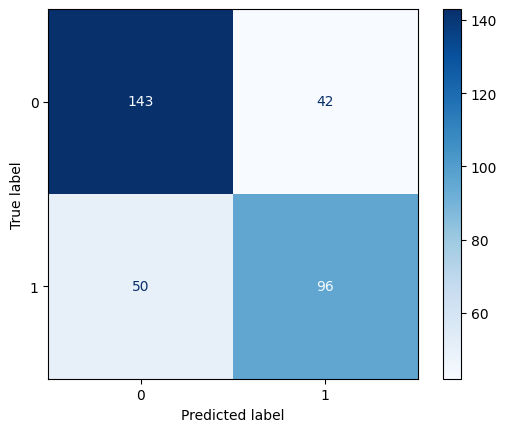

In [50]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Blues')
plt.show()

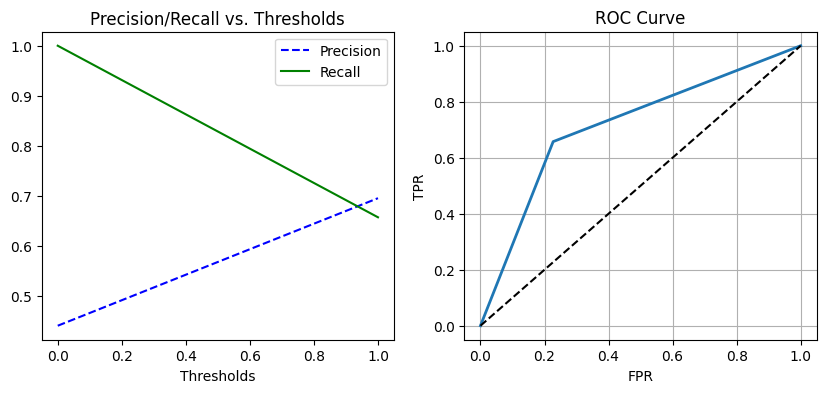

In [51]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_train, y_train_pred)
fpr, tpr, thresholds_roc = roc_curve(y_train, y_train_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [52]:
print(f"AUC: {roc_auc_score(y_train, y_train_pred)}.")

AUC: 0.7152536097741576.


#### Test Set

In [53]:
y_pred = cb_clf.predict(X_test)

In [54]:
print(f"Precision: {precision_score(y_test, y_pred)}.")
print(f"Recall: {recall_score(y_test, y_pred)}.")
print(f"F1 Score: {f1_score(y_test, y_pred)}.")

Precision: 0.7567567567567568.
Recall: 0.7368421052631579.
F1 Score: 0.7466666666666667.


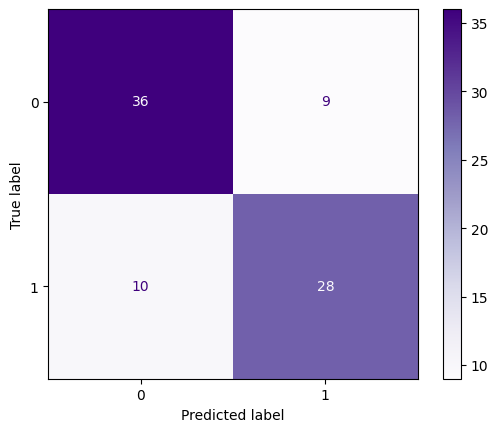

In [55]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Purples')
plt.show()

In [56]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}.")

Accuracy: 0.7710843373493976.


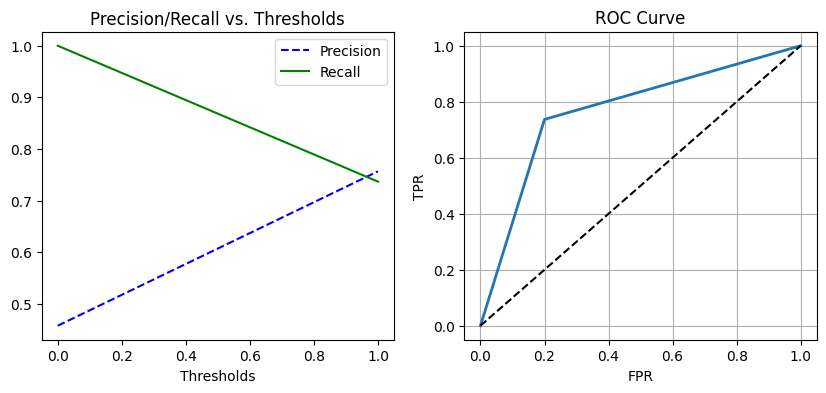

In [57]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [58]:
print(f"AUC: {roc_auc_score(y_test, y_pred)}.")

AUC: 0.768421052631579.


In [59]:
model_scores = pd.concat([model_scores, pd.DataFrame([{
    "Model": "CatBoost",
    "Accuracy": accuracy_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred)
}])], ignore_index=True)

___

## Logistic Regression

In [60]:
lr_clf = LogisticRegression()
lr_clf

LogisticRegression()

In [61]:
lr_clf.fit(X_train, y_train)

LogisticRegression()

In [62]:
cv_scores = cross_val_score(lr_clf, X_train, y_train, cv=3, scoring="accuracy", verbose=False)
cv_scores

array([0.77477477, 0.73636364, 0.7       ])

In [63]:
y_train_pred = cross_val_predict(lr_clf, X_train, y_train, cv=3)

print(f"Precision: {precision_score(y_train, y_train_pred)}.")
print(f"Recall: {recall_score(y_train, y_train_pred)}.")
print(f"F1 Score: {f1_score(y_train, y_train_pred)}.")

Precision: 0.7565217391304347.
Recall: 0.5958904109589042.
F1 Score: 0.6666666666666666.


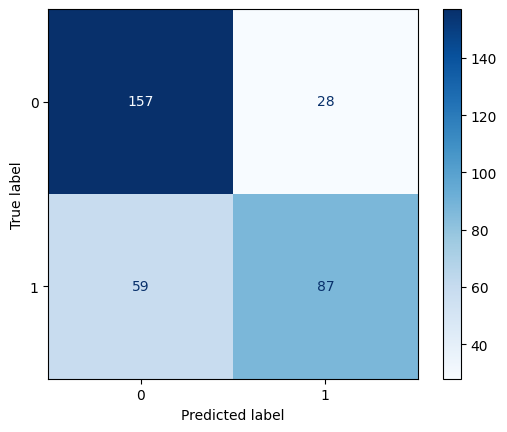

In [64]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Blues')
plt.show()

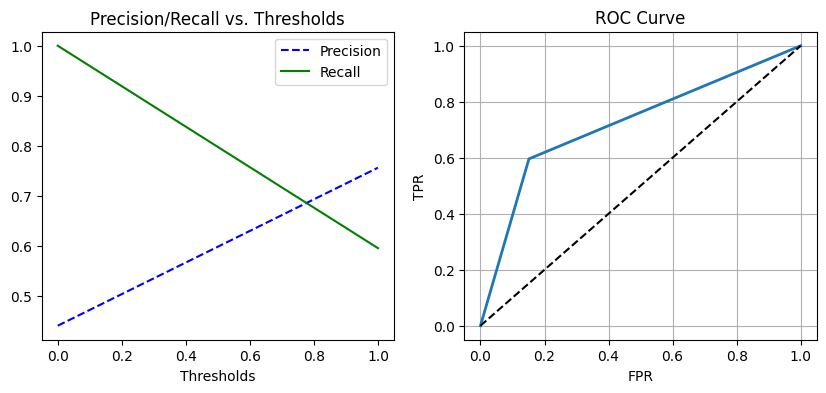

In [65]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_train, y_train_pred)
fpr, tpr, thresholds_roc = roc_curve(y_train, y_train_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [66]:
print(f"AUC: {roc_auc_score(y_train, y_train_pred)}.")

AUC: 0.7222695298037763.


#### Test Set

In [67]:
y_pred = lr_clf.predict(X_test)

In [68]:
print(f"Precision: {precision_score(y_test, y_pred)}.")
print(f"Recall: {recall_score(y_test, y_pred)}.")
print(f"F1 Score: {f1_score(y_test, y_pred)}.")

Precision: 0.7647058823529411.
Recall: 0.6842105263157895.
F1 Score: 0.7222222222222222.


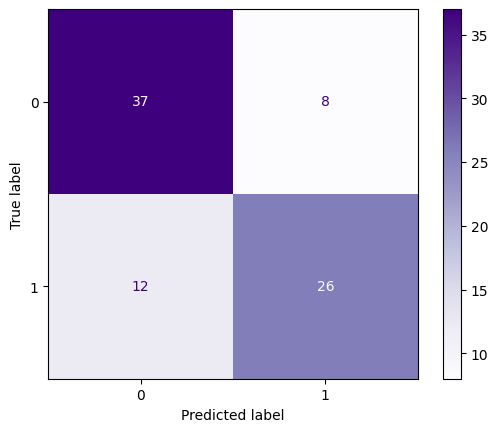

In [69]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Purples')
plt.show()

In [70]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}.")

Accuracy: 0.7590361445783133.


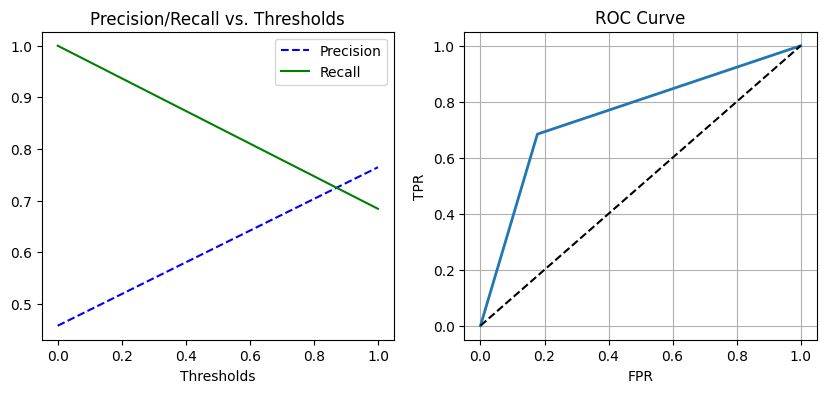

In [71]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [72]:
print(f"AUC: {roc_auc_score(y_test, y_pred)}.")

AUC: 0.7532163742690058.


In [73]:
model_scores = pd.concat([model_scores, pd.DataFrame([{
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred)
}])], ignore_index=True)

___

## Support Vector Machines

In [74]:
svm_clf = SVC(kernel='linear')
svm_clf

SVC(kernel='linear')

In [75]:
svm_clf.fit(X_train, y_train)

SVC(kernel='linear')

In [76]:
cv_scores = cross_val_score(svm_clf, X_train, y_train, cv=3, scoring="accuracy", verbose=False)
cv_scores

array([0.72972973, 0.71818182, 0.69090909])

In [77]:
y_train_pred = cross_val_predict(svm_clf, X_train, y_train, cv=3)

print(f"Precision: {precision_score(y_train, y_train_pred)}.")
print(f"Recall: {recall_score(y_train, y_train_pred)}.")
print(f"F1 Score: {f1_score(y_train, y_train_pred)}.")

Precision: 0.7524752475247525.
Recall: 0.5205479452054794.
F1 Score: 0.6153846153846153.


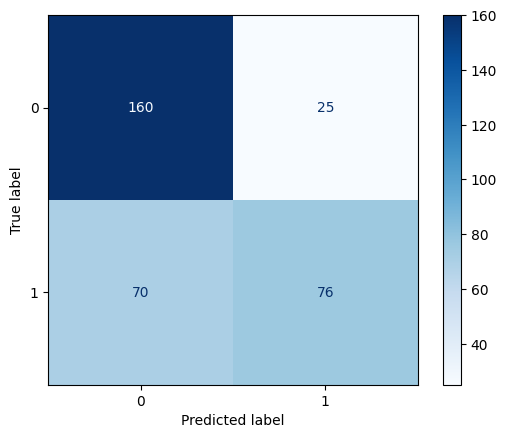

In [78]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Blues')
plt.show()

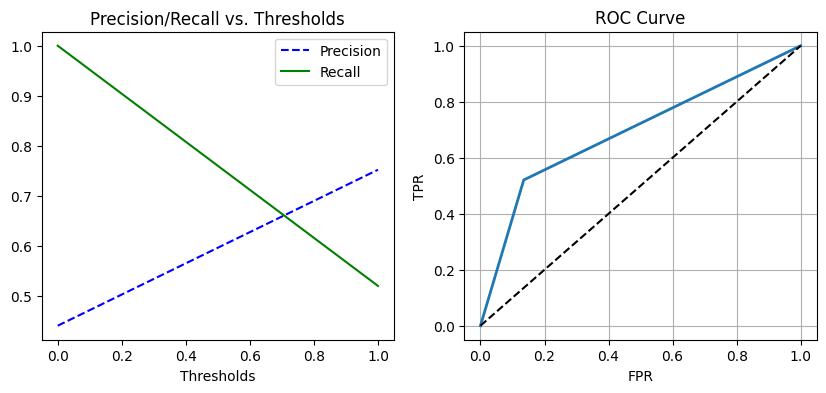

In [79]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_train, y_train_pred)
fpr, tpr, thresholds_roc = roc_curve(y_train, y_train_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

# plt.axvline(x=1.5*np.pi, color='black')
plt.show()

In [80]:
print(f"AUC: {roc_auc_score(y_train, y_train_pred)}.")

AUC: 0.6927064050351721.


#### Test Set

In [81]:
y_pred = svm_clf.predict(X_test)

In [82]:
print(f"Precision: {precision_score(y_test, y_pred)}.")
print(f"Recall: {recall_score(y_test, y_pred)}.")
print(f"F1 Score: {f1_score(y_test, y_pred)}.")

Precision: 0.7941176470588235.
Recall: 0.7105263157894737.
F1 Score: 0.7499999999999999.


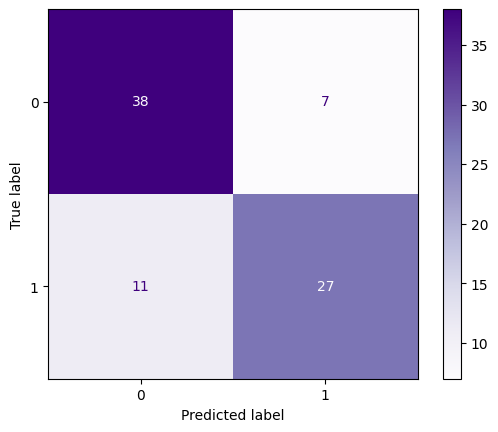

In [83]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Purples')
plt.show()

In [84]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}.")

Accuracy: 0.7831325301204819.


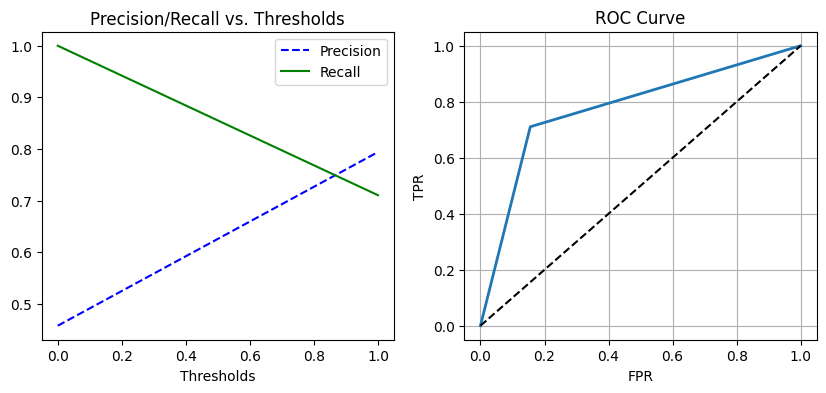

In [85]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [86]:
print(f"AUC: {roc_auc_score(y_test, y_pred)}.")

AUC: 0.777485380116959.


In [87]:
model_scores = pd.concat([model_scores, pd.DataFrame([{
    "Model": "SVM",
    "Accuracy": accuracy_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred)
}])], ignore_index=True)

## Decision Tree

In [88]:
dt_clf = DecisionTreeClassifier()
dt_clf

DecisionTreeClassifier()

In [89]:
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [90]:
cv_scores = cross_val_score(dt_clf, X_train, y_train, cv=3, scoring="accuracy", verbose=False)
cv_scores

array([0.56756757, 0.7       , 0.63636364])

In [91]:
y_train_pred = cross_val_predict(dt_clf, X_train, y_train, cv=3)

print(f"Precision: {precision_score(y_train, y_train_pred)}.")
print(f"Recall: {recall_score(y_train, y_train_pred)}.")
print(f"F1 Score: {f1_score(y_train, y_train_pred)}.")

Precision: 0.5785714285714286.
Recall: 0.5547945205479452.
F1 Score: 0.5664335664335666.


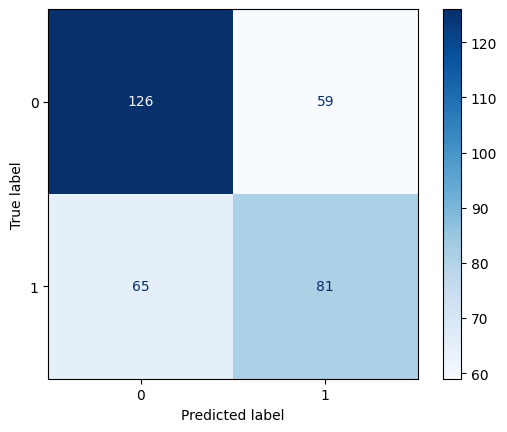

In [92]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Blues')
plt.show()

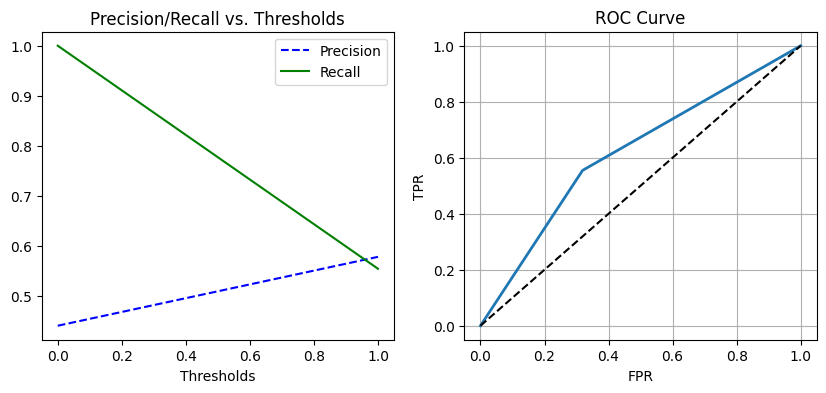

In [93]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_train, y_train_pred)
fpr, tpr, thresholds_roc = roc_curve(y_train, y_train_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [94]:
print(f"AUC: {roc_auc_score(y_train, y_train_pred)}.")

AUC: 0.6179378008145131.


#### Test Set

In [95]:
y_pred = dt_clf.predict(X_test)

In [96]:
print(f"Precision: {precision_score(y_test, y_pred)}.")
print(f"Recall: {recall_score(y_test, y_pred)}.")
print(f"F1 Score: {f1_score(y_test, y_pred)}.")

Precision: 0.6470588235294118.
Recall: 0.5789473684210527.
F1 Score: 0.6111111111111113.


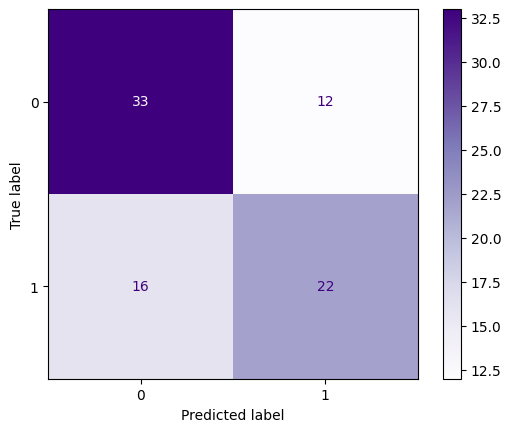

In [97]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Purples')
plt.show()

In [98]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}.")

Accuracy: 0.6626506024096386.


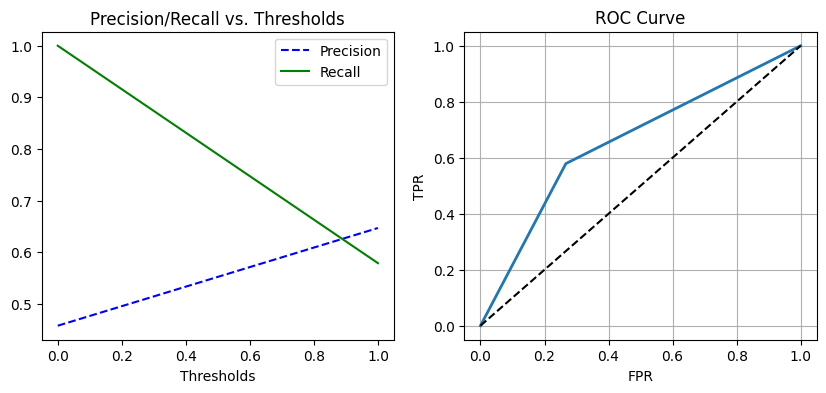

In [99]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [100]:
print(f"AUC: {roc_auc_score(y_test, y_pred)}.")

AUC: 0.656140350877193.


In [101]:
model_scores = pd.concat([model_scores, pd.DataFrame([{
    "Model": "Decision Tree",
    "Accuracy": accuracy_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred)
}])], ignore_index=True)

## Random Forest

In [102]:
rf_clf = RandomForestClassifier()
rf_clf

RandomForestClassifier()

In [103]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [104]:
cv_scores = cross_val_score(rf_clf, X_train, y_train, cv=3, scoring="accuracy")
cv_scores

array([0.72072072, 0.73636364, 0.7       ])

In [106]:
y_train_pred = cross_val_predict(rf_clf, X_train, y_train, cv=3)

print(f"Precision: {precision_score(y_train, y_train_pred)}.")
print(f"Recall: {recall_score(y_train, y_train_pred)}.")
print(f"F1 Score: {f1_score(y_train, y_train_pred)}.")

Precision: 0.6917293233082706.
Recall: 0.6301369863013698.
F1 Score: 0.6594982078853046.


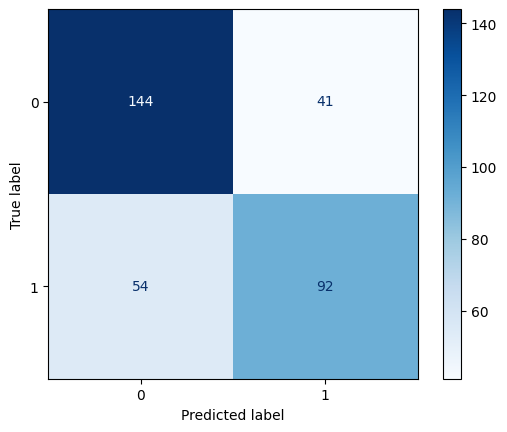

In [107]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Blues')
plt.show()

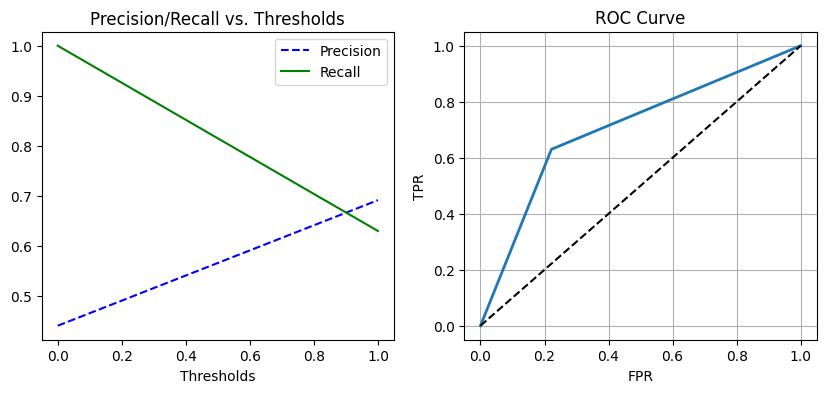

In [108]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_train, y_train_pred)
fpr, tpr, thresholds_roc = roc_curve(y_train, y_train_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [109]:
print(f"AUC: {roc_auc_score(y_train, y_train_pred)}.")

AUC: 0.7042576823398741.


#### Test Set

In [110]:
y_pred = rf_clf.predict(X_test)

In [111]:
print(f"Precision: {precision_score(y_test, y_pred)}.")
print(f"Recall: {recall_score(y_test, y_pred)}.")
print(f"F1 Score: {f1_score(y_test, y_pred)}.")

Precision: 0.7272727272727273.
Recall: 0.631578947368421.
F1 Score: 0.676056338028169.


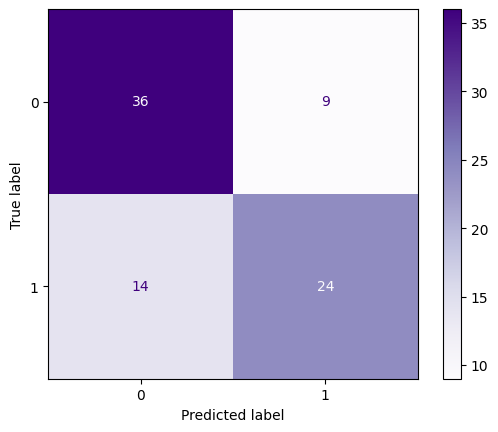

In [112]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Purples')
plt.show()

In [113]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}.")

Accuracy: 0.7228915662650602.


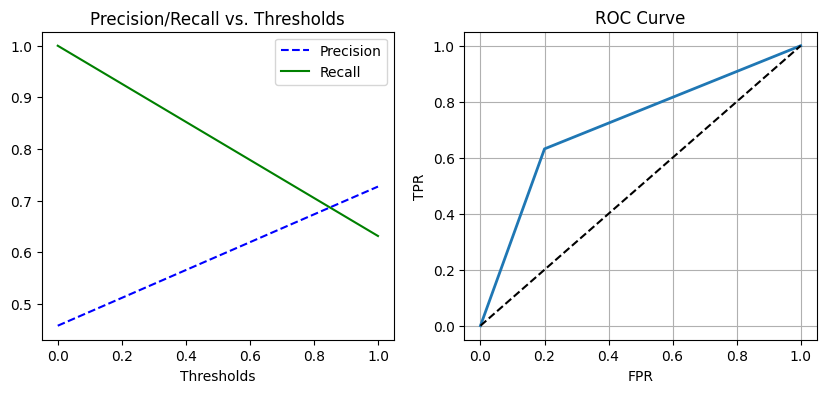

In [114]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [115]:
print(f"AUC: {roc_auc_score(y_test, y_pred)}.")

AUC: 0.7157894736842105.


In [116]:
model_scores = pd.concat([model_scores, pd.DataFrame([{
    "Model": "Random Forest",
    "Accuracy": accuracy_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred)
}])], ignore_index=True)

## XGBoost Classifier

In [117]:
xgb_clf = xgb.XGBClassifier()
xgb_clf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [118]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [119]:
cv_scores = cross_val_score(xgb_clf, X_train, y_train, cv=3, scoring="accuracy", verbose=False)
cv_scores

array([0.65765766, 0.65454545, 0.67272727])

In [120]:
y_train_pred = cross_val_predict(xgb_clf, X_train, y_train, cv=3)

print(f"Precision: {precision_score(y_train, y_train_pred)}.")
print(f"Recall: {recall_score(y_train, y_train_pred)}.")
print(f"F1 Score: {f1_score(y_train, y_train_pred)}.")

Precision: 0.6180555555555556.
Recall: 0.6095890410958904.
F1 Score: 0.6137931034482759.


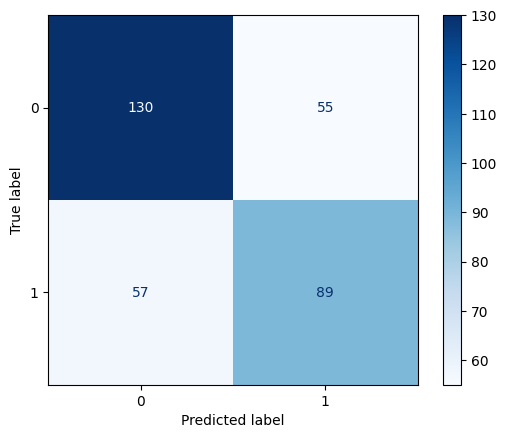

In [121]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Blues')
plt.show()

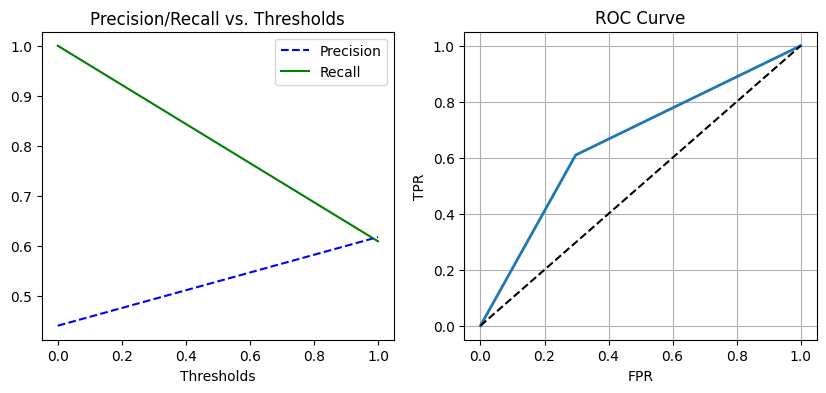

In [122]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_train, y_train_pred)
fpr, tpr, thresholds_roc = roc_curve(y_train, y_train_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [123]:
print(f"AUC: {roc_auc_score(y_train, y_train_pred)}.")

AUC: 0.6561458718992965.


#### Test Set

In [124]:
y_pred = xgb_clf.predict(X_test)

In [125]:
print(f"Precision: {precision_score(y_test, y_pred)}.")
print(f"Recall: {recall_score(y_test, y_pred)}.")
print(f"F1 Score: {f1_score(y_test, y_pred)}.")

Precision: 0.7058823529411765.
Recall: 0.631578947368421.
F1 Score: 0.6666666666666667.


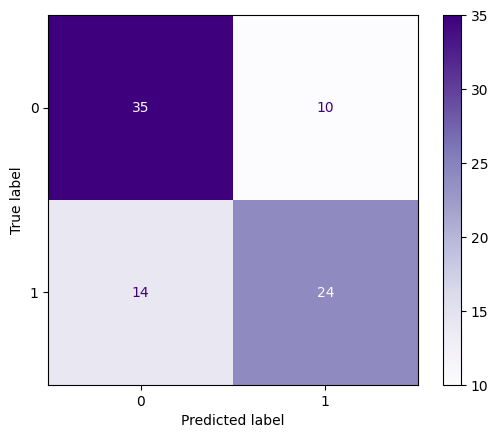

In [126]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Purples')
plt.show()

In [127]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}.")

Accuracy: 0.7108433734939759.


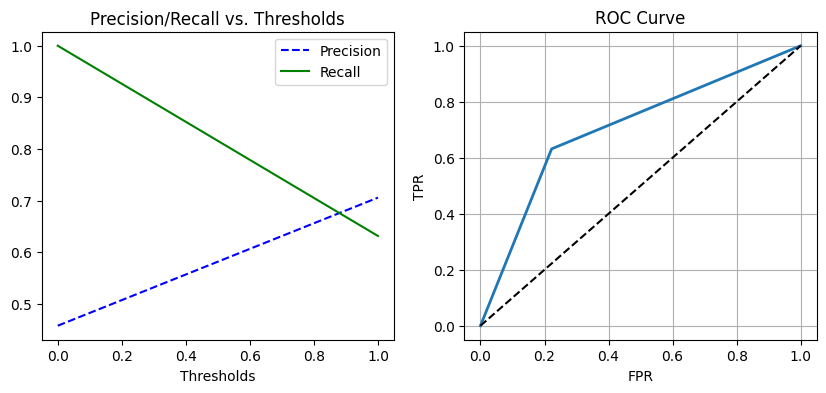

In [128]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [129]:
print(f"AUC: {roc_auc_score(y_test, y_pred)}.")

AUC: 0.7046783625730995.


In [130]:
model_scores = pd.concat([model_scores, pd.DataFrame([{
    "Model": "XGB",
    "Accuracy": accuracy_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred)
}])], ignore_index=True)

## MLP Classifier

In [131]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000)

In [132]:
mlp_clf.fit(X_train, y_train)

C:\Users\User\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000)

In [133]:
cv_scores = cross_val_score(mlp_clf, X_train, y_train, cv=3, scoring="accuracy", verbose=False)
cv_scores

array([0.75675676, 0.65454545, 0.68181818])

In [135]:
y_train_pred = cross_val_predict(mlp_clf, X_train, y_train, cv=3)

print(f"Precision: {precision_score(y_train, y_train_pred)}.")
print(f"Recall: {recall_score(y_train, y_train_pred)}.")
print(f"F1 Score: {f1_score(y_train, y_train_pred)}.")

Precision: 0.6971830985915493.
Recall: 0.678082191780822.
F1 Score: 0.6875.


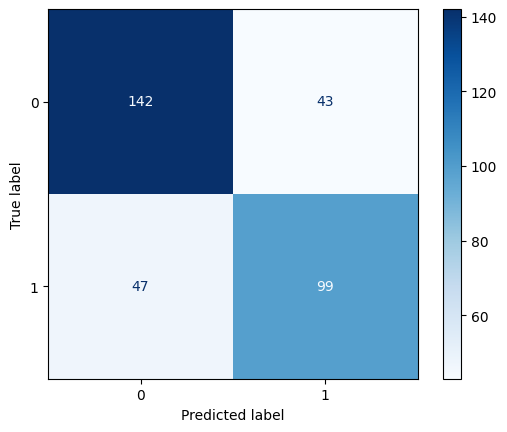

In [136]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Blues')
plt.show()

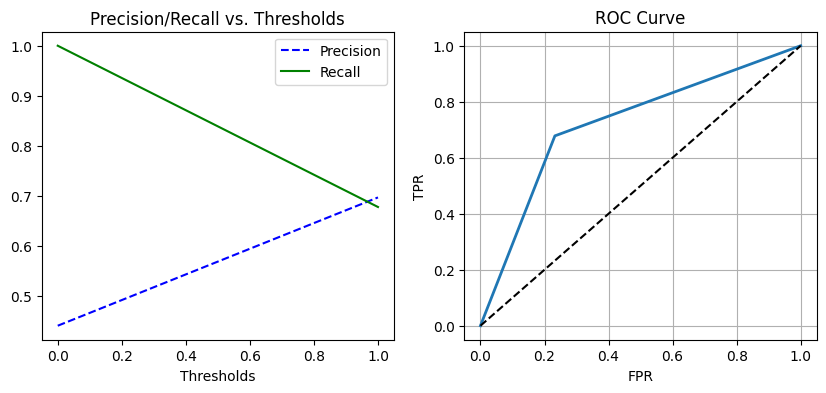

In [137]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_train, y_train_pred)
fpr, tpr, thresholds_roc = roc_curve(y_train, y_train_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [138]:
print(f"AUC: {roc_auc_score(y_train, y_train_pred)}.")

AUC: 0.7228248796741947.


#### Test Set

In [139]:
y_pred = mlp_clf.predict(X_test)

In [140]:
print(f"Precision: {precision_score(y_test, y_pred)}.")
print(f"Recall: {recall_score(y_test, y_pred)}.")
print(f"F1 Score: {f1_score(y_test, y_pred)}.")

Precision: 0.7419354838709677.
Recall: 0.6052631578947368.
F1 Score: 0.6666666666666666.


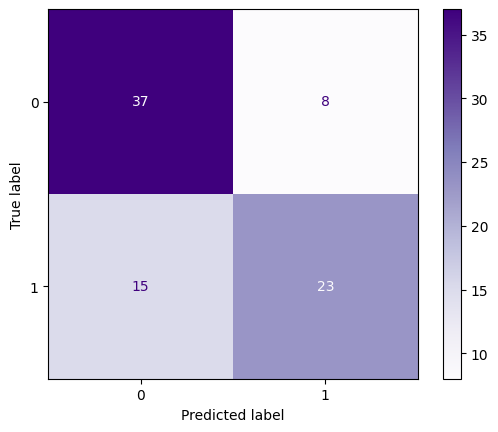

In [141]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Purples')
plt.show()

In [142]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}.")

Accuracy: 0.7228915662650602.


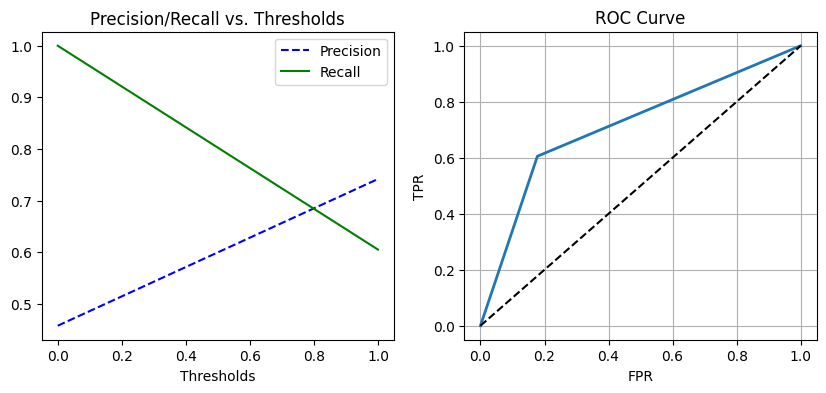

In [143]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [144]:
print(f"AUC: {roc_auc_score(y_test, y_pred)}.")

AUC: 0.7137426900584795.


In [145]:
model_scores = pd.concat([model_scores, pd.DataFrame([{
    "Model": "MLP",
    "Accuracy": accuracy_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred)
}])], ignore_index=True)

## Naive Bayes

In [146]:
nb = GaussianNB()

In [147]:
nb.fit(X_train, y_train)

GaussianNB()

In [148]:
cv_scores = cross_val_score(nb, X_train, y_train, cv=3, scoring="accuracy", verbose=False)
cv_scores

array([0.63963964, 0.54545455, 0.62727273])

In [149]:
y_train_pred = cross_val_predict(nb, X_train, y_train, cv=3)

print(f"Precision: {precision_score(y_train, y_train_pred)}.")
print(f"Recall: {recall_score(y_train, y_train_pred)}.")
print(f"F1 Score: {f1_score(y_train, y_train_pred)}.")

Precision: 0.5369458128078818.
Recall: 0.7465753424657534.
F1 Score: 0.6246418338108882.


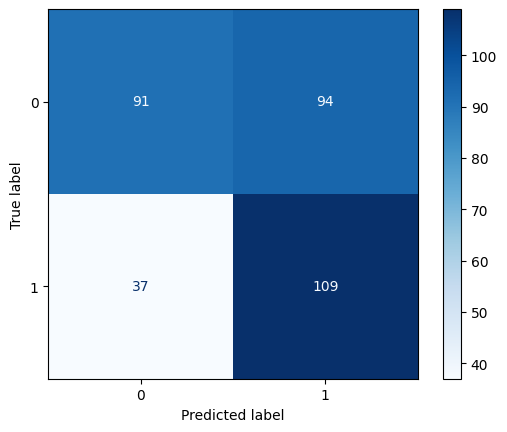

In [150]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Blues')
plt.show()

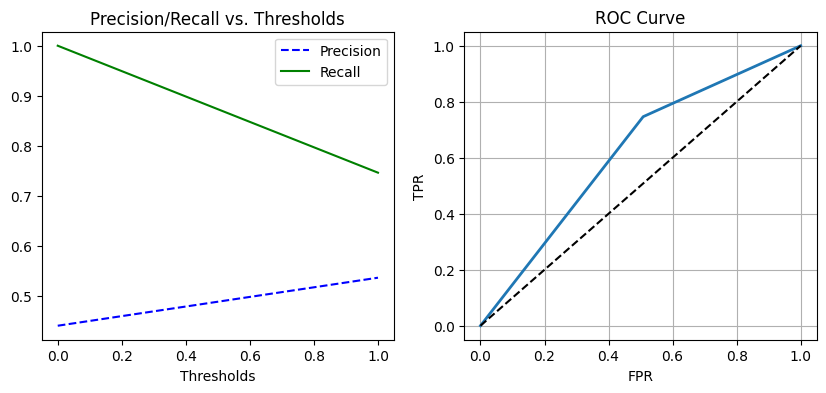

In [151]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_train, y_train_pred)
fpr, tpr, thresholds_roc = roc_curve(y_train, y_train_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [152]:
print(f"AUC: {roc_auc_score(y_train, y_train_pred)}.")

AUC: 0.6192336171788226.


#### Test Set

In [153]:
y_pred = nb.predict(X_test)

In [154]:
print(f"Precision: {precision_score(y_test, y_pred)}.")
print(f"Recall: {recall_score(y_test, y_pred)}.")
print(f"F1 Score: {f1_score(y_test, y_pred)}.")

Precision: 0.6875.
Recall: 0.868421052631579.
F1 Score: 0.7674418604651162.


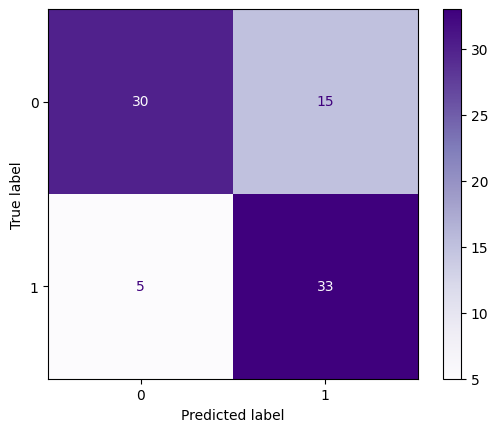

In [155]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Purples')
plt.show()

In [156]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}.")

Accuracy: 0.7590361445783133.


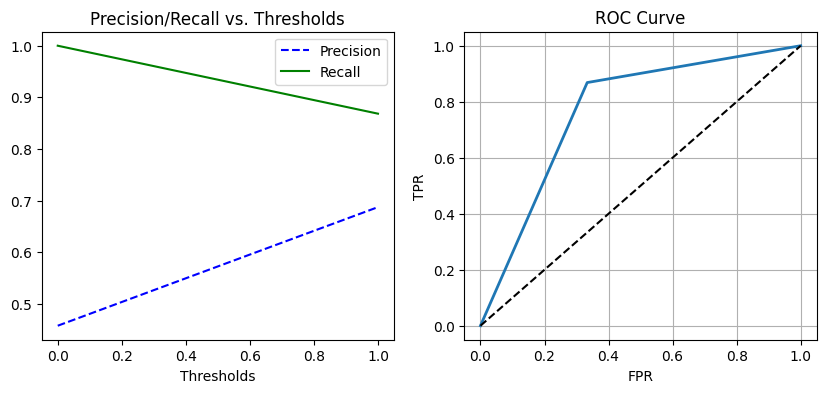

In [157]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [158]:
print(f"AUC: {roc_auc_score(y_test, y_pred)}.")

AUC: 0.7675438596491229.


In [159]:
model_scores = pd.concat([model_scores, pd.DataFrame([{
    "Model": "NB",
    "Accuracy": accuracy_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred)
}])], ignore_index=True)

In [160]:
# cv_model_scores.to_csv("cv_model_scores.csv", index=False)

In [161]:
model_scores

,Model,Accuracy,AUC
0,SGD,0.698795,0.695614
1,CatBoost,0.771084,0.768421
2,Logistic Regression,0.759036,0.753216
3,SVM,0.783133,0.777485
4,Decision Tree,0.662651,0.656140
5,Random Forest,0.722892,0.715789
6,XGB,0.710843,0.704678
7,MLP,0.722892,0.713743
8,NB,0.759036,0.767544
